# Potabilità dell'Acqua: analisi e predizione delle classi

In questo notebook è stata eseguita un'analisi ed esplorazione del dataset 'water potability', contenente più di 3000 samples e 10 colonne (9 features, 1 classe) che descrivono diversi campioni di acqua.

Principali scoperte durante l'analisi:
- non vi sono differenze statisticamente significative nei valori delle features discriminando i diversi campioni per classe d'appartenenza;
- molte features presentano valori distribuiti in modo approssimativamente Normale, con pochi outlier ciascuno;
- non ci sono features ridondanti, ognuna porta una buona quantità informativa al dataset.

Successivamente, è stato condotto un esperimento di previsione il cui obbiettivo era, intuibilmente, quello di classificare in modo corretto i diversi samples basandosi sulle features a disposizione.
- la metrica scelta è stata la __Accuracy__, sufficientemente esaustiva per un problema di classificazione binaria;
- Baseline Model come Benchmark: Classificatore Randomico Stratificato e Classificatore 'Maggioritario';
- Accuracy di riferimento: 51% (ottenuta dal Classificatore Rand. Strat.);
- impiegata tecnica di _oversampling_ (SMOTE) per fare fronte allo sbilanciamento tra classi, che però non ha portato i frutti attesi;
- modelli di confronto: __Random Forest, Logistic Regression__ e __KNN__

E' stato possibile superare le performance di riferimento impiegando __Random Forest__ o __KNN__.

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import (SimpleImputer, KNNImputer)
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import plotly.io as pio
pio.renderers.default = 'colab'


In [2]:
SEED = 42

#### Nota sul Seed

Il 'Seed' fa riferimento all'indice della sequenza di numeri pseudo-randomici da impiegare per l'addestramento di modelli e non solo; stabilire a priori un _seed_ garantisce la riproducibilità dei modelli o più in generale dei metodi impiegati che lo utilizzano, permettendo di riottenere i risultati riscontrati originalmente. 

Per garantire che l'intero workflow dia stabilmente i risultati sperati, è buona pratica rieseguire i blocchi di codice ciascuna volta con un seed diverso, per potersi assicurare che i risultati non siano _seed-dependent_ (ovvero, vincolati dalla sequenza particolare dei numeri). <br>In questo notebook, l'intero workflow si basa sul famoso seed 42; cambiando seed è verosimile ottenere dei risultati leggermente diversi e invalidare così alcuni dei commenti posti nelle celle in markdown, mentre l'intero codice è scritto in modo tale da garantire la maggior flessibilità possibile.

## Informazioni Generali sul Dataset

In [3]:
water_df = pd.read_csv("water_potability.csv")
water_df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [4]:
water_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


Tutte le features sono del giusto datatype (float); 'Potability' sarà la colonna target di riferimento:

In [5]:
water_df['Potability'].unique()

array([0, 1], dtype=int64)

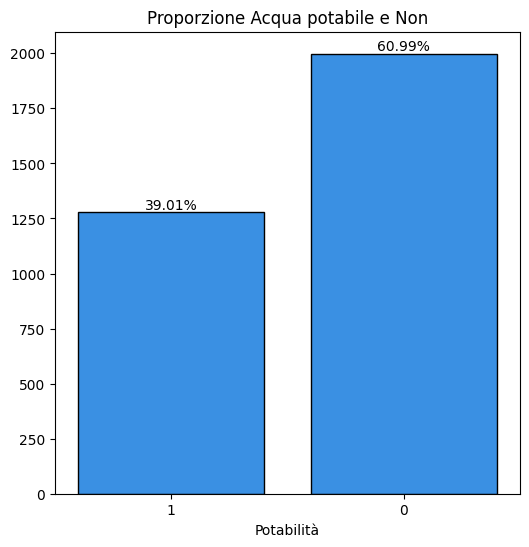

In [6]:
fig, ax = plt.subplots(figsize=(6,6))

sns.countplot(water_df,
              x='Potability', 
              color='dodgerblue', 
              edgecolor='k',
              order=water_df['Potability'].value_counts(ascending=True).index,
              ax=ax)

for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/len(water_df))*100:0.2f}%')

ax.set_title("Proporzione Acqua potabile e Non")
ax.set_xlabel("Potabilità")
ax.set_ylabel("")
plt.show()

Descrizione delle colonne:

1. ph: pH of 1. water (0 to 14).
2. Hardness: Capacity of water to precipitate soap in mg/L.
3. Solids: Total dissolved solids in ppm.
4. Chloramines: Amount of Chloramines in ppm.
5. Sulfate: Amount of Sulfates dissolved in mg/L.
6. Conductivity: Electrical conductivity of water in μS/cm.
7. Organic_carbon: Amount of organic carbon in ppm.
8. Trihalomethanes: Amount of Trihalomethanes in μg/L.
9. Turbidity: Measure of light emiting property of water in NTU.
10. Potability: Indicates if water is safe for human consumption. Potable -1 and
Not potable -0

L'ultima colonna sarà il target.

3 features - _ph, Sulfate, Trihalomethanes_ - hanno valori mancanti, i primi due in quantità non trascurabile.

## Split in Training e Test set

applico la stratificazione: voglio che entrambi i dataset riportino fedelmente la sproporzione tra le due classi di potabilità. <br>
Se impiegassi una tecnica di sampling randomica, correrei il rischio di avere un training set 'casualmente' bilanciato oppure eccessivamente sbilanciato. L'intento di tenere la proporzione tra classi è __prioritaria nel test set__ che dovrà simulare al meglio le circostanze del problema reale, mentre il training set potrebbe anche essere sottoposto a qualche tecnica di bilanciamento (_oversampling_ per la classe minoritaria e _undersampling_ per quella maggioritaria).

In [7]:
X = water_df.drop('Potability', axis=1)
y = water_df['Potability']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=SEED,
                                                    stratify=y,
                                                    test_size=0.2)

Formo un dataframe composto dai soli dati di train e uno dai dati di test:

In [8]:
water_train = pd.concat([X_train, y_train], axis=1)
water_test = pd.concat([X_test, y_test], axis=1)

## EDA

L'esplorazione dei dati ed il suo preprocessing verrà effettuato solo sul __training set__: questo per simulare la situazione in cui si debba interagire con dei dati nuovi, mai visti prima: il __test set__ svolgerà quel ruolo.

In prima battuta, voglio vedere come sono distribuiti i dati delle diverse features:

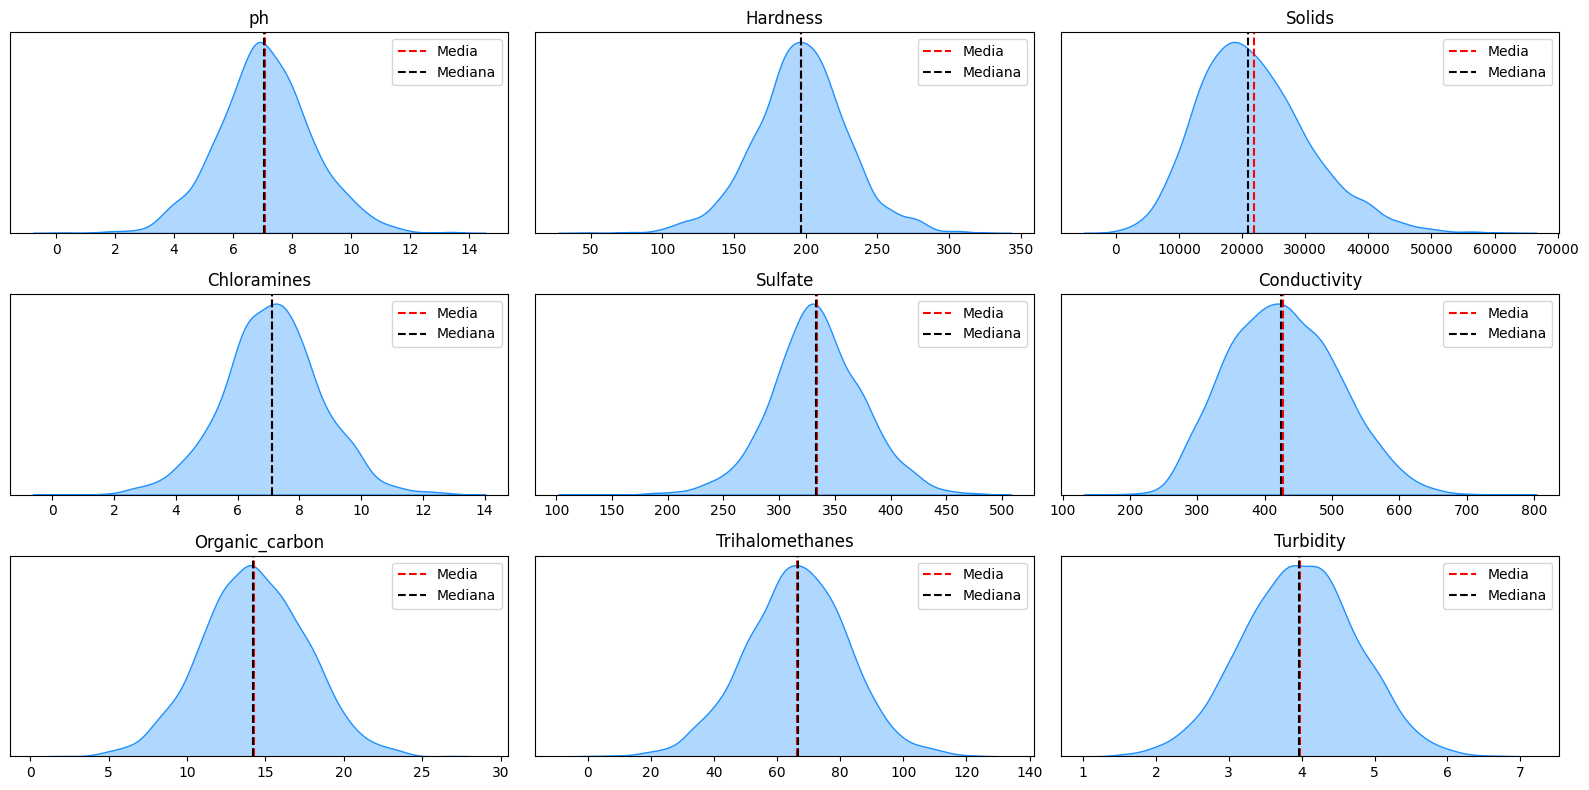

In [9]:
def kde_plot(dataframe):
    '''
    la funzione restituisce una matrice composta da [n x 3] grafici, ciascuno dei quali mostra la distribuzione dei dati usando un kdeplot per ogni colonna;
    l'argomento necessario è un dataframe (pandas)
    '''
    
    if len(dataframe.columns)%3 == 0:
        nrows = len(dataframe.columns)//3
    else:
        nrows = (len(dataframe.columns)//3)+1
        
    fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=(16,8))
    ax = ax.ravel()

    used_axes = 0
    
    for i, feat in enumerate(dataframe.columns):
        kde = sns.kdeplot(data=dataframe,
                        x=feat,
                        color='dodgerblue',
                        fill=True,
                        alpha=0.35,
                        ax=ax[i])
    
        ax[i].set_ylabel('')
        ax[i].set_yticks([]) 
        ax[i].set_xlabel('')
        ax[i].set_title(feat)
        
        ax[i].axvline(x=dataframe[feat].mean(), color='r', label='Media',linestyle='--')
        ax[i].axvline(x=dataframe[feat].median(), color='k', label='Mediana',linestyle='--')
        ax[i].legend()

        used_axes += 1
    
    for j in range(used_axes, len(ax)):
        ax[j].axis('off')

    plt.tight_layout()

kde_plot(water_train.drop(columns='Potability'))

Notiamo due peculiarità:
- Tutte le features seguono una distribuzione simile alla normale; _'Solids'_ si discosta sensibilmente, mostrando una asimmetria positiva; le linee della Media e della Mediana sono molto vicine tra loro nelle distribuzioni quasi Normali mentre in quelle con asimmetria positiva, la media viene 'trascinata' verso la coda destra; nelle distribuzioni Normali, sono sovrapposte;
- Le features rientrano in scale di valori diverse, tra loro: ad esempio, la scala di _'Solids'_ è circa $10^4$
 volte maggiore rispetto a '_Turbidity_'. Andranno eventualmente standardizzate.

### Test di verifica di ipotesi: T-Test su due gruppi

Lo scopo del T-Test è verificare l'eventuale differenza tra le medie di due gruppi: in questo caso, ciascuna feature appartenente all'acqua potabile e non.

Assunzioni per un T-test di Student:

- Normalità distribuzione
- Indipendenza delle osservazioni
- Stessa varianza <br>

Le distribuzioni sono solo approssimativamente normali e sappiamo che le osservazioni sono indipendenti tra loro.

Controlliamo comunque sia la prima che la terza condizione, prima con dei grafici:

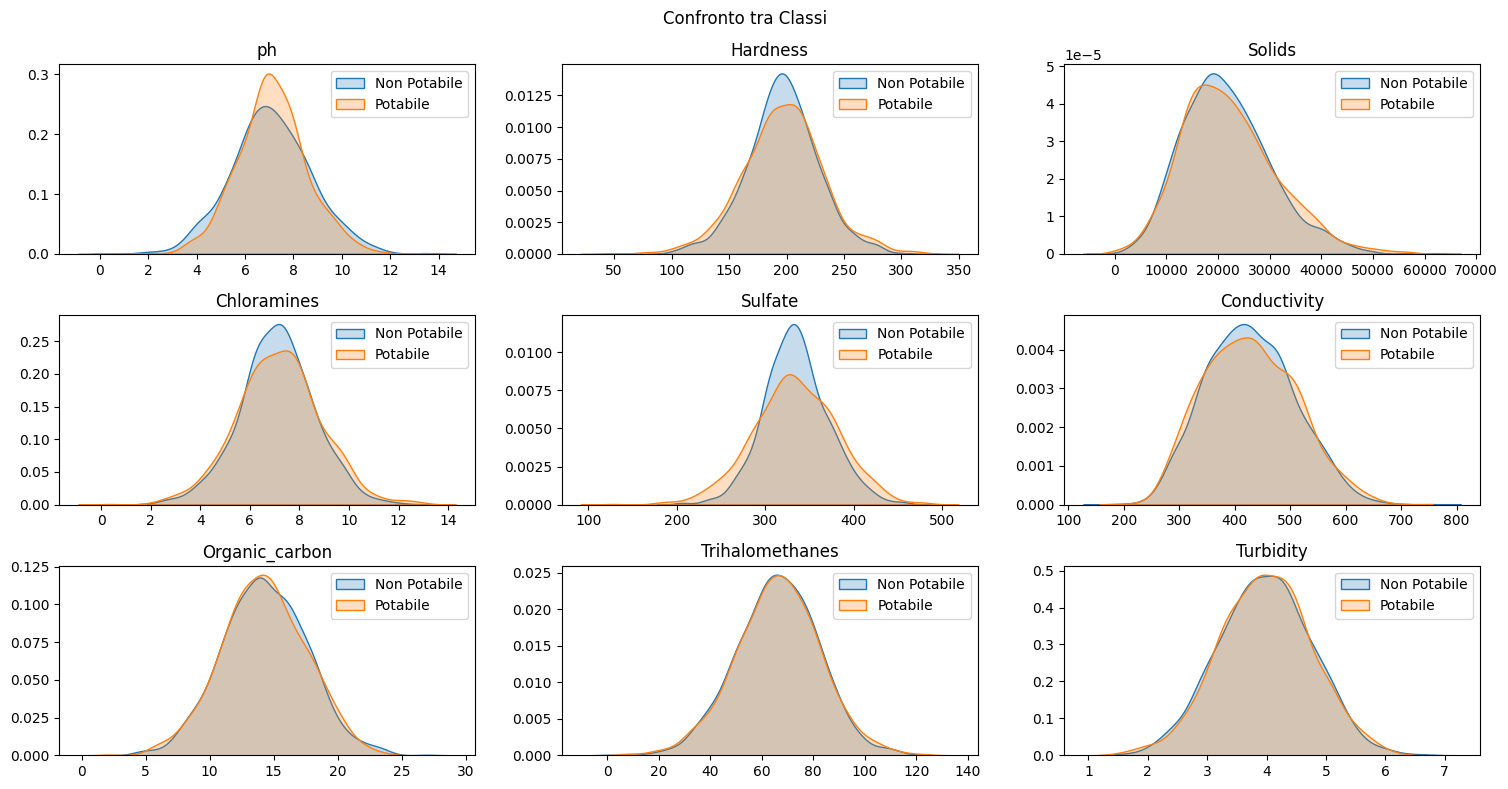

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,8))
ax = ax.ravel()

water_train_0 = water_train.loc[water_train.Potability == 0]
water_train_1 = water_train.loc[water_train.Potability == 1]

for i, col in enumerate(water_train.columns[:-1]):

    sns.kdeplot(water_train_0.drop('Potability',axis=1)[col], label='Non Potabile', fill=True, ax=ax[i])
    sns.kdeplot(water_train_1.drop('Potability',axis=1)[col], label='Potabile', fill=True, ax=ax[i])
    ax[i].set_title(f"{col}")
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].legend()

plt.suptitle("Confronto tra Classi")
plt.tight_layout()
plt.show()

Alcune distribuzioni potrebbero non essere Normali;

di seguito, una serie di test statistici per garantire la applicabilità del T-test di Student:
1. Utilizzo un test di __Shapiro__: la sua _ipotesi nulla_ è che i dati provengano da una distribuzione normale. __Se p-value < alfa, rifiutiamo H0__;
2. Test di __Levene__ per verificare uguaglianza delle varianze: la sua __H0__ è che siano uguali;
3. Con varianze disuguali, test di __Welch__, viceversa __T-Test di Student__

In [11]:
from scipy import stats
from scipy.stats import mannwhitneyu



cols_div = []

for col in water_train.columns[:-1]:
    # verifica della normalità con test Shapiro

    print('___________________________________________________________\n')
    stat_potabile, p_potabile = stats.shapiro(water_train_1[col].dropna())
    stat_non_potabile, p_non_potabile = stats.shapiro(water_train_0[col].dropna())
    print(f"Normalità per {col}:")
    print(f"  Potabile: p-value = {p_potabile:.4f}")
    print(f"  Non Potabile: p-value = {p_non_potabile:.4f}")

    # se anche solo uno non è Normale, eseguo test di Mann-Whitney U
    if p_potabile <= 0.05 or p_non_potabile <= 0.05:
        print("Non normale, calcolo del test di Mann-Whitney per la differenza:")
        stat, p_value = mannwhitneyu(water_train_1[col], water_train_0[col],
                                    nan_policy='omit')
        print(f"Test di Mann-Whitney per {col}: p-value = {p_value}")
        if p_value > 0.05:
            print("Non c'è una differenza significativa")
        else:
            print(f"Differenza tra le distribuzioni della feature {col}")
            cols_div.append(col)
    else:
        print("Normale")
        # Test di Levene per verificare l'uguaglianza delle varianze
        stat_levene, p_levene = stats.levene(
            water_train_1[col],  
            water_train_0[col]  
        )
        print(f"Test di Levene per {col}: p-value = {p_levene:.4f}")
        
        # t-test dopo aver verificato normalità 
        if p_levene > 0.05:  # Varianze uguali
            stat_ttest, p_ttest = stats.ttest_ind(
                water_train_1[col],
                water_train_0[col],
                nan_policy='omit'
            )
        else:  # varianze disuguali, t-test di Welch
            stat_ttest, p_ttest = stats.ttest_ind(
                water_train_1[col],
                water_train_0[col],
                equal_var=False,
                nan_policy='omit'
            )
        
        print(f"T-test per {col}: p-value = {p_ttest:.4f}\n")
        if p_ttest > 0.05:
            print("Nessuna differenza tra le medie")
        else:
            print("Differenza tra le medie")
            cols_div.append(col)

print('___________________________________________________________')
print("\nFeature con differenze statisticamente significative (con alpha=0.05):", len(cols_div))
if len(cols_div) > 0:
    print(cols_div)

___________________________________________________________

Normalità per ph:
  Potabile: p-value = 0.0003
  Non Potabile: p-value = 0.1243
Non normale, calcolo del test di Mann-Whitney per la differenza:
Test di Mann-Whitney per ph: p-value = 0.5112657056221037
Non c'è una differenza significativa
___________________________________________________________

Normalità per Hardness:
  Potabile: p-value = 0.0001
  Non Potabile: p-value = 0.0004
Non normale, calcolo del test di Mann-Whitney per la differenza:
Test di Mann-Whitney per Hardness: p-value = 0.9695692962989518
Non c'è una differenza significativa
___________________________________________________________

Normalità per Solids:
  Potabile: p-value = 0.0000
  Non Potabile: p-value = 0.0000
Non normale, calcolo del test di Mann-Whitney per la differenza:
Test di Mann-Whitney per Solids: p-value = 0.3376887144485069
Non c'è una differenza significativa
___________________________________________________________

Normalità per Ch

#### Una precisazione su alpha

ho optato per alpha pari a __0.05__ poiché è quello impiegato convenzionalmente nei test statistici. Il livello di significatività fa riferimento alla probabilità di rifiutare l'ipotesi nulla quando invece è vera (errore del primo tipo, falso negativo). <br>

Se la ricerca avesse uno scopo puramente esplorativo, sarebbe accettabile alzarlo sino a __0.1__; se invece si volesse mantenere un'attitudine molto conservativa a causa della gravità scaturita da un falso positivo, si abbasserebbe alpha sino a __0.01__

Se si fosse in campo sperimentale, sarebbe accettabile impiegare un livello di significatività più alto, ma non oltre __0.1__, altrimenti perderebbe di senso fare test di ipotesi.

### Valori Mancanti

In [12]:
water_train.isna().sum()

ph                 387
Hardness             0
Solids               0
Chloramines          0
Sulfate            625
Conductivity         0
Organic_carbon       0
Trihalomethanes    134
Turbidity            0
Potability           0
dtype: int64

Il dataframe presenta dei dati mancanti, come notato precedentemente. Prima di agire con eventuali sostituzioni, bisogna capire la natura della assenza di questi valori: 

In [13]:
water_train[['ph','Sulfate','Trihalomethanes']].isna().corr()

,ph,Sulfate,Trihalomethanes
ph,1.000000,-0.015948,0.001010
Sulfate,-0.015948,1.000000,0.012335
Trihalomethanes,0.001010,0.012335,1.000000


Non c'è correlazione tra nessuno dei valori mancanti: vale a dire, l'assenza dei valori è verosimilmente completamente randomica, definita __MCAR__.  <br> 

Quello dei dati mancanti è un problema: occorre stabilire come procedere. Le strade percorribili sono diverse:
- Eliminare colonna con molti valori mancanti;
- Eliminare righe con tutti e 3 i valori mancanti;
- Imputare un valore laddove mancante;

Considerando le dimensioni del dataset abbastanza contenute, eliminare dei dati sembra un'opzione poco conveniente. <br> Voglio optare per una soluzione mista:
1. Elimino le righe contenenti valori mancanti in tutte e tre le colonne in esame;
2. Imputo un valore;

La scelta del valore da imputare è un'altra questione delicata: considerando la distribuzione normale, potrebbe essere una buona scelta una tra media e mediana. Il dataset però è abbastanza piccolo e ci consentirebbe dunque di testare qualche alternativa computazionalmente più costosa.

Prima ancora, voglio verificare la presenza di outlier nel dataset:

In [14]:
def outlier_spotter(dataframe):
    for col in dataframe.columns:
        Q1 = dataframe[col].quantile(0.25)
        Q3 = dataframe[col].quantile(0.75)
        IQR = Q3-Q1
        out_low = Q1 - IQR*1.5
        out_up = Q3 + IQR*1.5
        number = dataframe[col].apply(lambda x: 1 if x < out_low or x > out_up else 0).sum()
        print(f"Outlier in {col}: {number/len(dataframe)*100:.2f}%")

outlier_spotter(water_train)

Outlier in ph: 1.34%
Outlier in Hardness: 2.79%
Outlier in Solids: 1.37%
Outlier in Chloramines: 2.02%
Outlier in Sulfate: 1.30%
Outlier in Conductivity: 0.27%
Outlier in Organic_carbon: 0.76%
Outlier in Trihalomethanes: 0.99%
Outlier in Turbidity: 0.53%
Outlier in Potability: 0.00%


Gli outlier sono pochissimi; <br>
considerando ciò e la forma delle distribuzioni, valuterò diverse opzioni per sostituire i valori mancanti.

Prima elimino le righe contenenti un valore mancante in ogni colonna possibile (ovvero 3).

In [15]:
water_train[water_train.isnull().sum(axis=1) >= 3]

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
992,NaN,226.765646,39942.953898,8.594715,NaN,538.621803,13.744749,NaN,4.863378,0
3062,NaN,209.531697,44982.734155,8.898024,NaN,349.385235,15.653299,NaN,3.832479,0
141,NaN,167.386127,20944.620814,4.963124,NaN,566.339294,11.318807,NaN,3.679795,0
929,NaN,202.079864,12519.090660,7.627524,NaN,399.883388,12.748217,NaN,4.439215,0
387,NaN,143.300200,16263.167465,6.229737,NaN,503.664085,19.585497,NaN,3.451740,1
2065,NaN,184.993731,19764.627445,7.505092,NaN,293.477998,12.934160,NaN,3.017985,0
3067,NaN,193.091260,17777.100086,6.087949,NaN,543.114953,10.717588,NaN,3.878664,0
646,NaN,221.620058,11954.700730,6.657053,NaN,391.238714,12.961433,NaN,3.282061,0


In [16]:
water_train = water_train[water_train.isnull().sum(axis=1) < 3]
water_train

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
2214,7.822492,208.636720,22308.821729,5.850328,408.123255,502.789396,16.135732,60.393982,3.835332,0
1634,6.037428,227.033994,12988.791229,8.476905,392.380529,306.386283,7.122391,41.190507,3.594217,1
2605,8.445219,228.522860,28966.569327,6.179855,NaN,361.705354,14.554220,60.612230,4.400706,0
114,6.745307,218.424637,21871.838700,7.165509,NaN,373.050102,16.826619,74.086080,3.902353,0
129,6.506488,202.285938,17087.076902,6.201983,326.662368,481.771934,16.535186,46.205748,3.548776,0
...,...,...,...,...,...,...,...,...,...,...
101,7.348845,223.264940,11519.046527,8.889559,NaN,494.158434,18.145374,73.715522,4.880875,0
1734,3.928556,191.665998,17328.161457,7.692417,306.479558,406.085614,9.578602,45.480738,5.060836,0
461,7.163999,203.781598,34226.072127,9.412035,320.258917,415.577513,16.221044,90.184208,3.354322,0
2242,6.645657,170.269715,23432.109730,7.066565,NaN,513.364946,20.264678,78.900888,4.170658,0


In [17]:
imputer = SimpleImputer(strategy='median')
imputer.fit(water_train)
water_train_imputed = imputer.transform(water_train)

water_train_imputed = pd.DataFrame(water_train_imputed, columns=water_train.columns)

In [18]:
water_train_imputed.isna().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

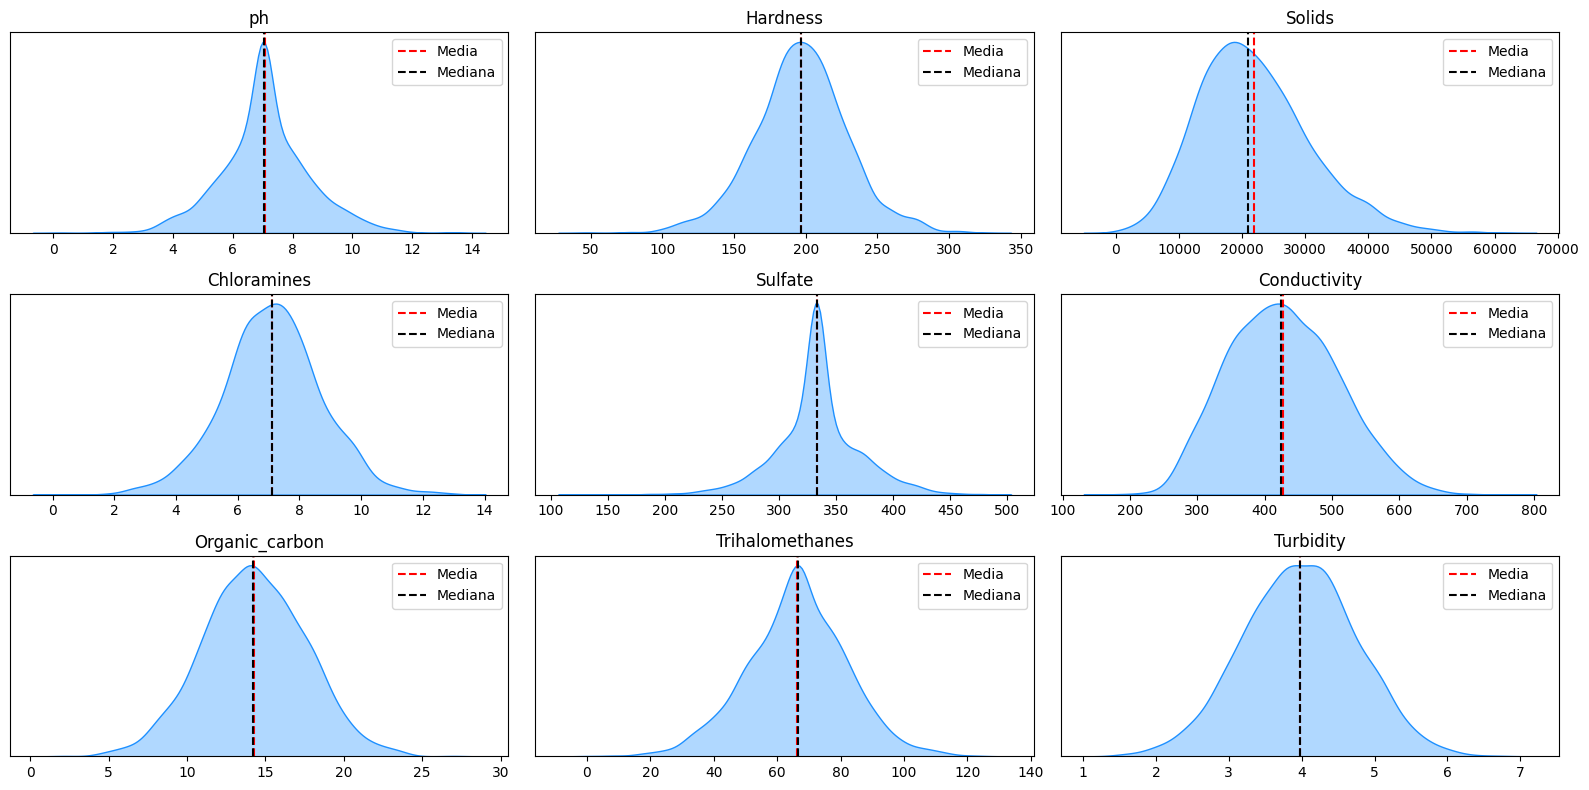

In [19]:
kde_plot(water_train_imputed.drop('Potability', axis=1))

_Sulfate_ e _ph_ hanno logicamente perso molta variabilità. Proviamo una strategia alternativa: __KNN Imputer__

In [20]:
knn_imputer = KNNImputer()
knn_imputer.fit(water_train)
water_train_knn = knn_imputer.transform(water_train)
water_train_knn = pd.DataFrame(water_train_knn, columns=water_train.columns)

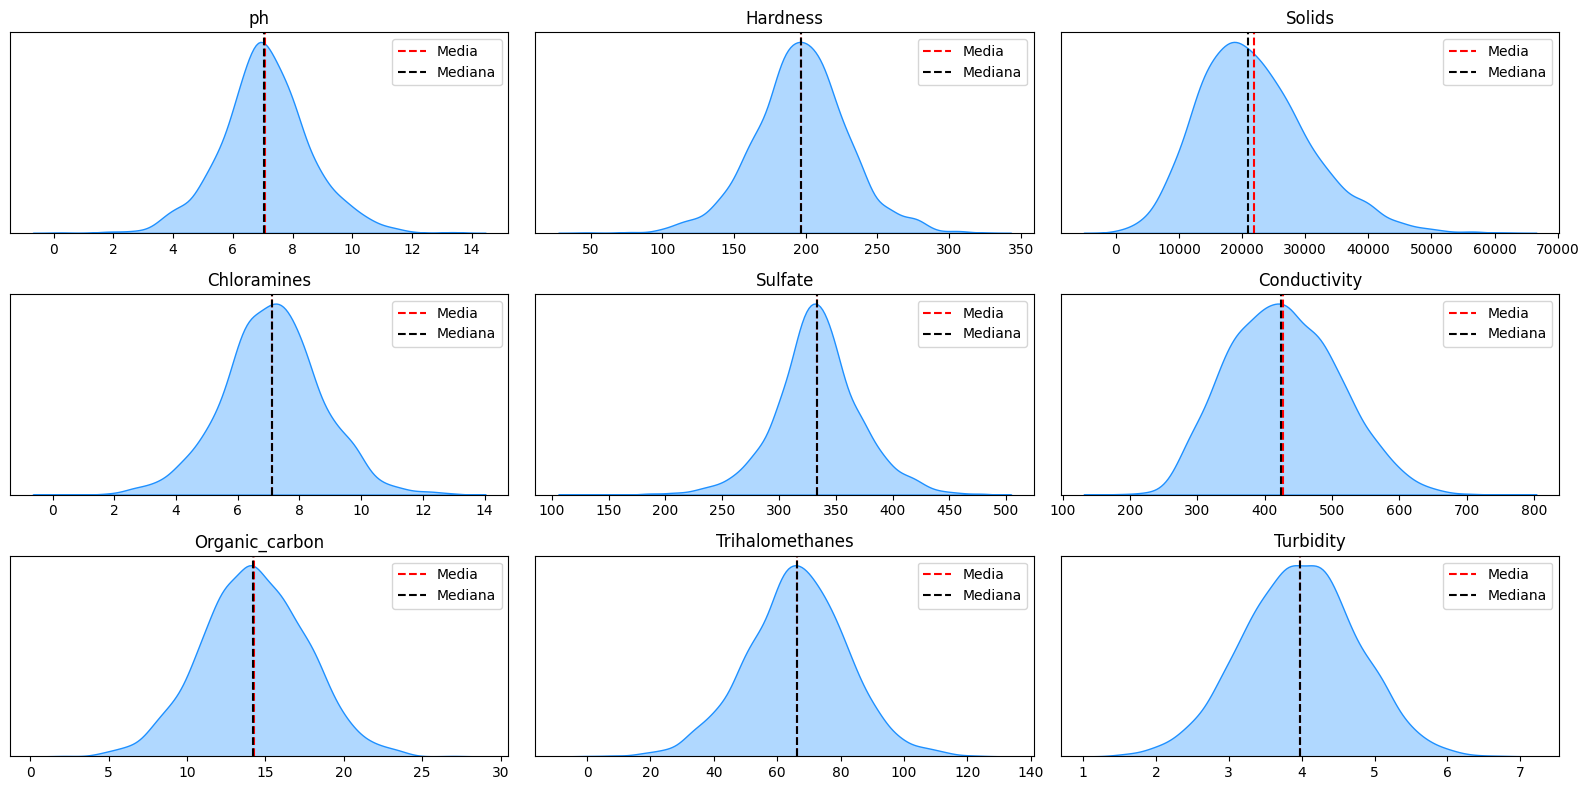

In [21]:
kde_plot(water_train_knn.drop('Potability',axis=1))

Sembra che KNN_Imputer riesca a conservare più fedelmente la forma della distribuzione.

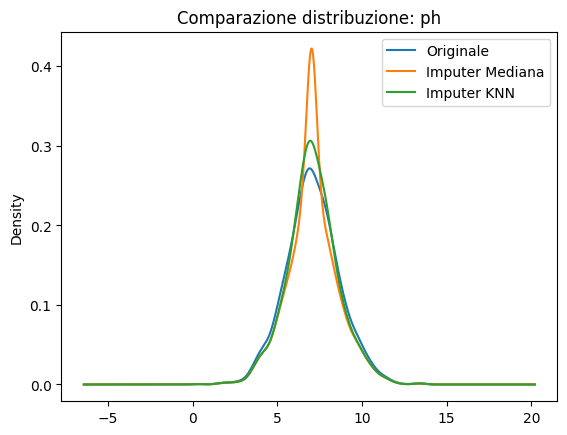

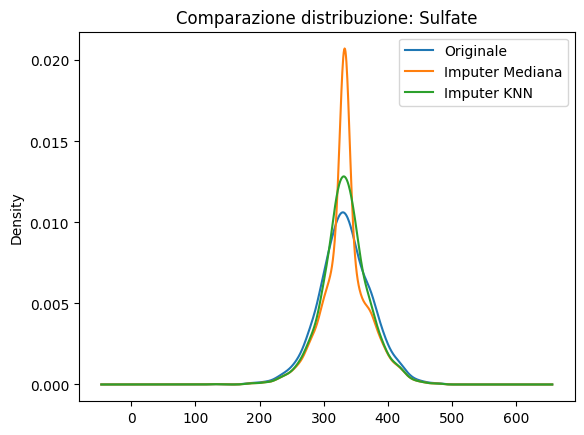

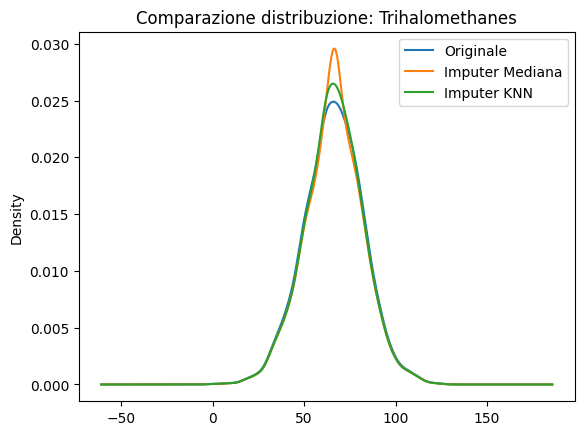

In [22]:
for col in ['ph','Sulfate','Trihalomethanes']:
    water_train[col].plot(kind='density', label='Originale', legend=True)
    water_train_imputed[col].plot(kind='density', label='Imputer Mediana', legend=True)
    water_train_knn[col].plot(kind='density', label='Imputer KNN' , legend=True)
    plt.title(f'Comparazione distribuzione: {col}')
    plt.show()

D'ora in avanti procedo con i valori imputati da __KNN Imputer__: sembra capace di imputare i dati in modo più preciso rispetto alla controparte.

In [23]:
w_train = water_train_knn
outlier_spotter(w_train)

Outlier in ph: 2.30%
Outlier in Hardness: 2.79%
Outlier in Solids: 1.34%
Outlier in Chloramines: 2.03%
Outlier in Sulfate: 3.91%
Outlier in Conductivity: 0.27%
Outlier in Organic_carbon: 0.77%
Outlier in Trihalomethanes: 1.57%
Outlier in Turbidity: 0.54%
Outlier in Potability: 0.00%


L'imputazione dei dati mancanti è necessaria per poter utilizzare alcuni algoritmi.

### Outlier per classe:

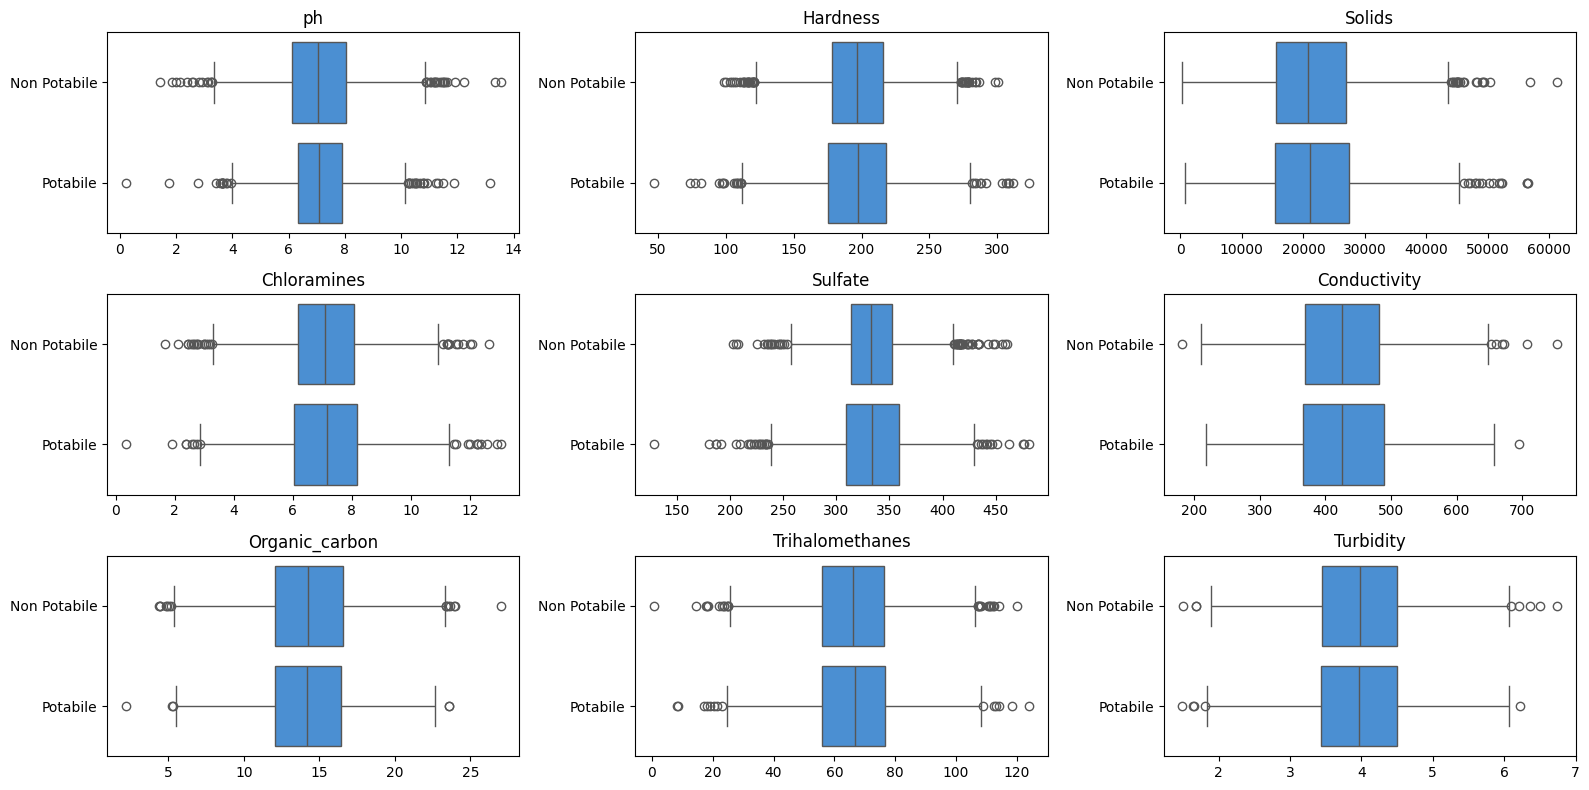

In [24]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16, 8))
ax = ax.ravel()

for i, col in enumerate(w_train.columns.drop('Potability')):
    ax[i] = sns.boxplot(x=w_train[col], 
                        y=w_train['Potability'].astype('category'), 
                        ax=ax[i],
                        color='dodgerblue',
                        saturation=.6)
    
    ax[i].set_yticks([0, 1])
    ax[i].set_yticklabels(['Non Potabile','Potabile'])
    ax[i].set_xlabel('')
    ax[i].set_title(col)
    ax[i].set_ylabel('')

plt.tight_layout()

Complessivamente si nota un comportamento simile a prescindere dalla classe. <br> Più precisamente:

In [25]:
w_train_0 = w_train.loc[w_train["Potability"] == 0].drop('Potability', axis=1)
w_train_1 = w_train.loc[w_train["Potability"] == 1].drop('Potability', axis=1)

print("Acqua non potabile:")
outlier_spotter(w_train_0)

Acqua non potabile:
Outlier in ph: 2.14%
Outlier in Hardness: 2.89%
Outlier in Solids: 1.32%
Outlier in Chloramines: 1.76%
Outlier in Sulfate: 3.14%
Outlier in Conductivity: 0.44%
Outlier in Organic_carbon: 0.88%
Outlier in Trihalomethanes: 1.57%
Outlier in Turbidity: 0.50%


In [26]:
print("Acqua potabile:")
outlier_spotter(w_train_1)

Acqua potabile:
Outlier in ph: 3.33%
Outlier in Hardness: 2.64%
Outlier in Solids: 1.47%
Outlier in Chloramines: 1.86%
Outlier in Sulfate: 3.33%
Outlier in Conductivity: 0.10%
Outlier in Organic_carbon: 0.49%
Outlier in Trihalomethanes: 1.37%
Outlier in Turbidity: 0.49%


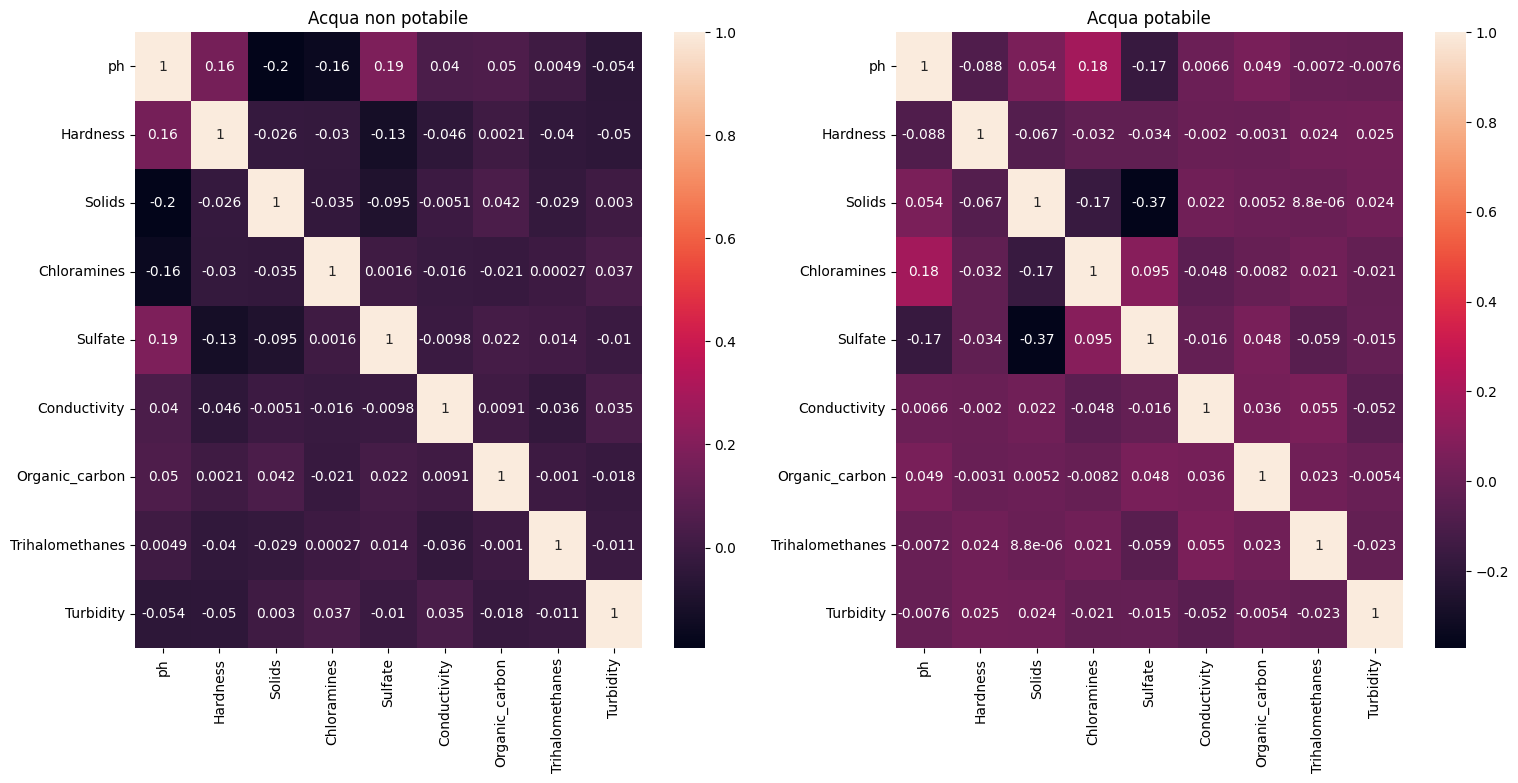

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax  = ax.ravel()

sns.heatmap(w_train_0.corr(), annot=True, ax = ax[0])
sns.heatmap(w_train_1.corr(), annot=True, ax = ax[1])
ax[0].set_title("Acqua non potabile")

ax[1].set_title("Acqua potabile");

C'è qualche _timida_ correlazione nell'Acqua Potabile (tra __Solids__ e __Sulfate__) ma complessivamente i valori sono prossimi allo 0 o comunque non superano i 0.2: non ci sono variabili correlate tra loro, per cui anche il rischio di multicollinearità è molto basso.<br> Questo significa nessuna colonna dà informazioni ridondanti rispetto a quanto traibile dalle altre features e che gli algoritmi lineari potrebbero non essere ottimali nella costruzione di un modello di classificazione efficace.

Considerando l'eterogeneità delle scale di valori, procedo con la standardizzazione: questo procedimento è essenziale per alcuni algoritmi (come ad esempio KNN).

In [28]:
scaler = StandardScaler()
scaler.fit(w_train.drop('Potability', axis=1))
w_scaled = scaler.transform(w_train.drop('Potability', axis=1))

w_scaled = pd.DataFrame(w_scaled, columns=w_train.drop('Potability', axis=1).columns)
w_scaled["Potability"] = w_train["Potability"]
w_scaled

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0.489042,0.370824,0.048494,-0.791423,1.976450,0.926613,0.564426,-0.363064,-0.178000,0.0
1,-0.702299,0.934314,-1.016919,0.850320,1.557379,-1.501997,-2.168854,-1.572045,-0.486843,1.0
2,0.904647,0.979917,0.809570,-0.585452,-0.171576,-0.817953,0.084835,-0.349324,0.546185,0.0
3,-0.229865,0.670618,-0.001459,0.030631,-0.421390,-0.677670,0.773937,0.498942,-0.092154,0.0
4,-0.389251,0.176305,-0.548426,-0.571621,-0.192038,0.666723,0.685560,-1.256304,-0.545049,0.0
...,...,...,...,...,...,...,...,...,...,...
2607,0.172933,0.818872,-1.184932,1.108249,0.077014,0.819887,1.173847,0.475613,1.161231,0.0
2608,-2.109747,-0.148973,-0.520867,0.359975,-0.729304,-0.269172,-1.424012,-1.301948,1.391742,0.0
2609,0.049568,0.222116,1.410807,1.434823,-0.362497,-0.151800,0.590297,1.512422,-0.794124,0.0
2610,-0.296370,-0.804320,0.176902,-0.031214,-0.288758,1.057384,1.816522,0.802065,0.251517,0.0


### Feature Selection

Il t-test non ha mostrato differenze tra gruppi etc; controlliamo se ci sono feats più importanti:

#### 1. Random Forest 'feature importance'

In [29]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=SEED)

model.fit(w_scaled.drop('Potability',axis=1), w_scaled.Potability)

importances = model.feature_importances_

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

In [30]:
feature_importance

,Feature,Importance
4,Sulfate,0.139832
0,ph,0.131417
3,Chloramines,0.117170
1,Hardness,0.116142
2,Solids,0.110022
5,Conductivity,0.099877
7,Trihalomethanes,0.096075
8,Turbidity,0.095041
6,Organic_carbon,0.094424


In [31]:
feature_importance.head(4)['Importance'].sum()

0.5045608829322554

Il Random Forest riesce a spiegare solo il 50% della varianza con quattro features. E' verosimile che nessuna delle feature sia rinunciabile, come anche visto nella correlation matrix. <br>


#### 2. Cluster Map

La clustermap rappresenta in modo grafico la 'vicinanza' tra diverse features in termini informativi.

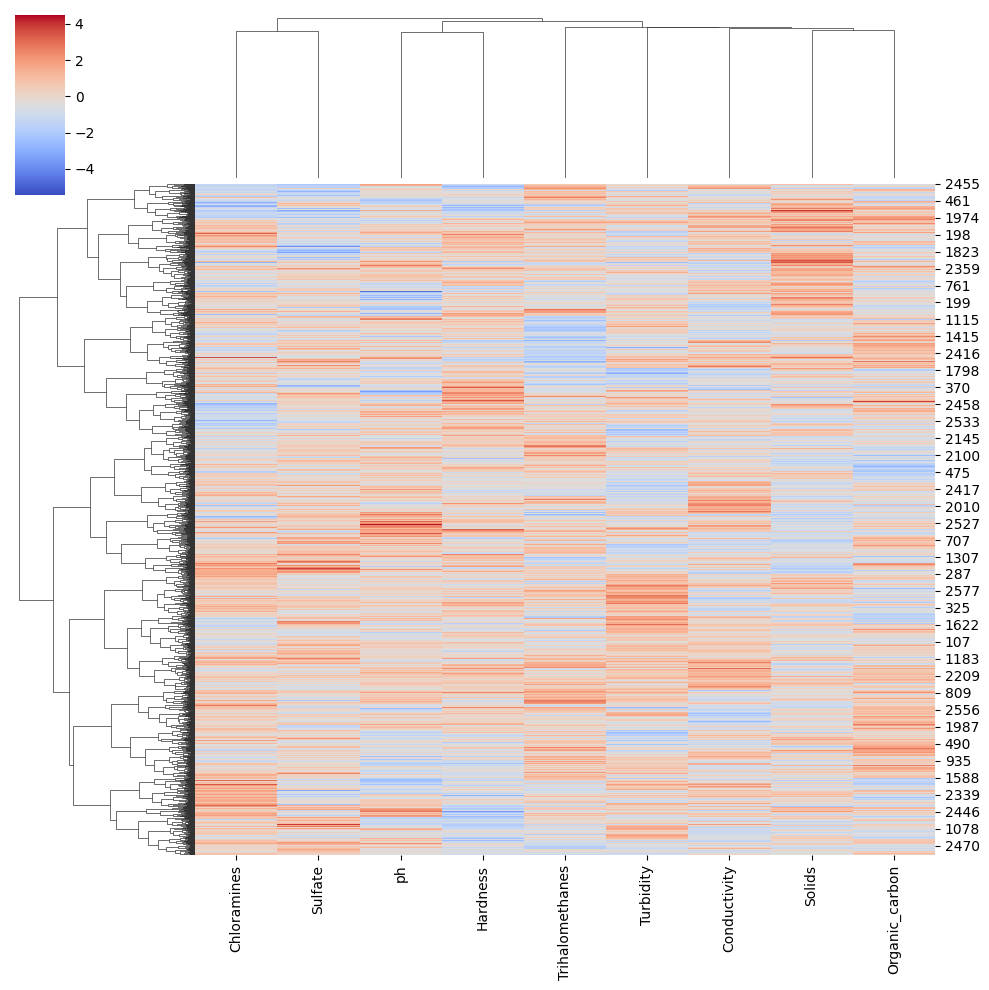

In [32]:
sns.clustermap(w_scaled.drop('Potability',axis=1), method='ward', cmap='coolwarm');

Il _dendogramma_ sopra mostra la ripartizione in cluster delle diverse features; ad esempio __Solids, Conductiviy, Organic_Carbon__ sono molto vicine tra loro, per cui saranno verosimilmente appartenenti allo stesso cluster.

In [33]:
from scipy.cluster.hierarchy import linkage, fcluster

linkage_matrix = linkage(w_scaled.drop('Potability',axis=1).T, method='ward') 
cluster_labels = fcluster(linkage_matrix, t=4, criterion='maxclust')  
features = w_scaled.drop('Potability',axis=1).columns

cluster_mapping = pd.DataFrame({"Feature": features, "Cluster": cluster_labels})

cluster_mapping.sort_values('Cluster')

,Feature,Cluster
3,Chloramines,1
4,Sulfate,1
0,ph,2
1,Hardness,2
2,Solids,3
5,Conductivity,3
6,Organic_carbon,3
8,Turbidity,3
7,Trihalomethanes,4


Dal dataframe, emerge l'esistenza di quattro diversi cluster nel dataset. L'ultimo cluster è comunque l'unico ad essere popolato da una sola feature;
il problema della clustermap è che nel suo sviluppo non prende in considerazione la natura del problema, ovvero di classificazione, e si limita piuttosto a creare dei raggruppamenti delle colonne più simili tra loro. <br>
Eventualmente, quanto trovato qua andrà combinato con un altro approccio.

#### 3. Test ANOVA

Un ulteriore approccio per identificare feature più rilevanti di altre è usare un test statistico, come fatto
in precedenza. Questa volta impiego ANOVA e Chi-2 ed uso 'SelectKBest' di sklearn per trattenere le 4 features che presentano un legame più forte (misurato col valore del Test) con 'Potability'.

In [34]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X_anova = w_scaled.drop('Potability', axis=1)
y_anova = w_scaled['Potability']

anova_selector = SelectKBest(f_classif, k=4)
X_kbest = anova_selector.fit_transform(X_anova, y_anova)
X_anova.columns[anova_selector.get_support()]

Index(['Solids', 'Chloramines', 'Sulfate', 'Organic_carbon'], dtype='object')

#### Test Chi-2

In [35]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

scaling = MinMaxScaler()
w_minmax = pd.DataFrame(scaling.fit_transform(w_train), columns=w_train.columns)

X_chi = w_minmax.drop('Potability', axis=1)
y_chi = w_train['Potability']

chi_selector = SelectKBest(chi2, k=4)
X_chi_Kbest = chi_selector.fit_transform(X_chi, y_chi)
X_chi.columns[chi_selector.get_support()]

Index(['Solids', 'Chloramines', 'Sulfate', 'Organic_carbon'], dtype='object')

#### 4. Mutual Information

Come intuibile dal nome, la Mutual Information calcola l'informazione che una variabile fornisce su un'altra (in questo caso sul target). <br>
In altri termini, risponde alla domanda: sapendo il valore di feature 'x', con quanta fiducia possiamo stimare 'y' (target)?

E' particolarmente utile nei dataset in cui i dati hanno relazioni non lineari tra loro.

In [36]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X_anova, y_anova, random_state=SEED)

mi_scores_series = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)
features_mi = mi_scores_series.nlargest(3).index.tolist()
mi_scores_series

Sulfate            0.023531
Hardness           0.023295
ph                 0.014015
Conductivity       0.006992
Organic_carbon     0.005979
Turbidity          0.003635
Solids             0.000000
Chloramines        0.000000
Trihalomethanes    0.000000
dtype: float64

Ci sono tre features completamente prive di informazione (_Chloramines, Trihalomethanes, Solids_) e tre features molto più informative delle rimanenti tre, impiegabili in una feature selection più avanti. I valori sono comunque bassissimi e non c'è una feature che spicca rispetto alle altre. <br> E' possibile ricorrere alla riduzione della dimensionalità ed apprezzare variazioni sensibili?

#### 5. PCA

Il PCA (__Principal Component Analysis__) è una tecnica di apprendimento non supervisionato, dotato di poca interpretabilità, che consente di allocare quanta più informazione possibile in un numero più piccolo di features (componenti), che non corrispondono perfettamente alle features già esistenti nel dataset.

In [37]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 4)
X4D = pca.fit_transform(w_scaled.drop('Potability',axis=1))
pca.explained_variance_ratio_.sum()

0.49809902977527837

Riducendo le features a quattro componenti, PCA riesce a spiegare solo la metà della varianza.

Text(0.5, 1.0, 'PCA')

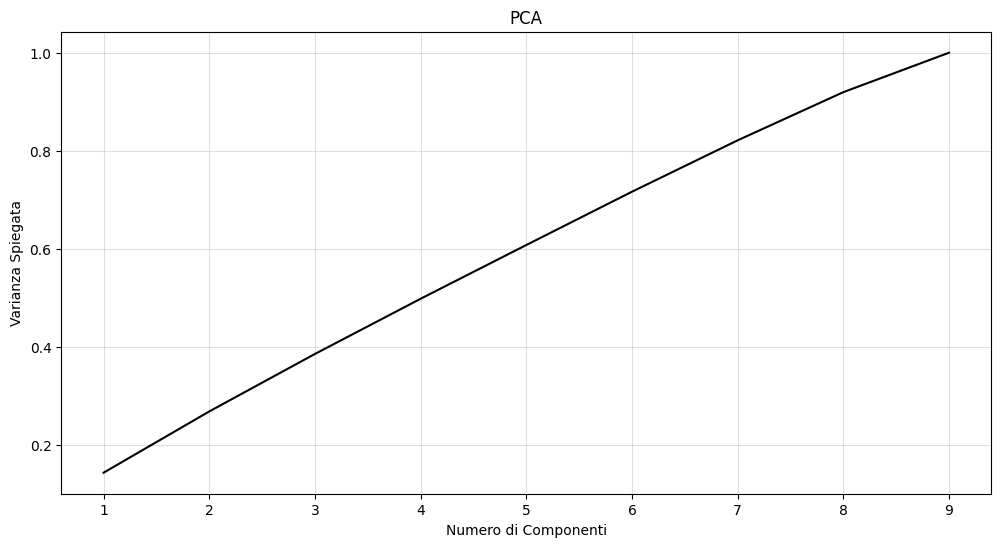

In [38]:
pca = PCA(n_components=9)
X_var = pca.fit_transform(w_scaled.drop('Potability',axis=1))

fig, ax = plt.subplots(figsize=(12,6))

sns.lineplot(x=range(1,10), y=pca.explained_variance_ratio_.cumsum(), ax=ax, color='k')
plt.grid(alpha=0.4)

ax.set_ylabel("Varianza Spiegata")
ax.set_xlabel("Numero di Componenti")
ax.set_title("PCA")

La pendenza della curva conferma che PCA attribuisce all'incirca un'importanza omogenea a ciascuna delle componenti da essa sintetizzata; in uno scenario ideale, ovvero di efficiente riduzione della dimensionalità, avremmo osservato una forma 'a gomito', vale a dire con una pendenza elevata sino a X = 2 (o 3) per poi appiattirsi.

In [39]:
pca = PCA(n_components = 3)
X3D = pca.fit_transform(w_scaled.drop('Potability',axis=1))

import plotly.express as px


df = pd.DataFrame({
    'PC1': X3D[:, 0],  
    'PC2': X3D[:, 1],  
    'PC3': X3D[:, 2],  
    'Class': w_scaled['Potability']   
})

fig = px.scatter_3d(
    df,
    x='PC1',               
    y='PC2',               
    z='PC3',               
    color='Class',         
    title='PCA: Visualizzazione 3D Interattiva',
    labels={'Class': 'Classe'},  
    opacity=0.7            
)

fig.show()

A conferma di quanto appurato sopra, neanche PCA riesce a 'mappare' i punti in modo che non vi siano molte sovrapposizioni, salvo qualche piccolo spazio marginale popolato prevalentemente da samples della classe 1.

### Bilanciamento del training set

Come sottolineato all'inizio dell'analisi, il dataset non è bilanciato: vale a dire che i possibili output di classificazione non si equivalgono numericamente.

Per questo motivo, talvolta è preferibile sottoporre il training set ad un bilanciamento, vale a dire togliendo alcuni esempi della classe maggioritaria o aggiungendone di 'sintetici' della classe minoritaria, rispettivamente __undersampling__ e __oversampling__. <br>
Visto che i dati non sono tantissimi, proverò alcuni approcci e valuterò poi i modelli su ciascuno dei training set risultanti. <br>
I metodi che proverò saranno  __SMOTE__ e __ADASYN__.

In [40]:
X_scaled = w_scaled.drop('Potability',axis=1)
y_scaled = w_scaled['Potability']

In [41]:
from collections import Counter
Counter(y_scaled)

Counter({0.0: 1591, 1.0: 1021})

In [42]:
from imblearn.over_sampling import SMOTE
smt = SMOTE(sampling_strategy=1, random_state=SEED)
X_, y_ = smt.fit_resample(X_scaled, y_scaled)
Counter(y_)

Counter({0.0: 1591, 1.0: 1591})

In [43]:
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(sampling_strategy=1, random_state=SEED)
xx, yy = adasyn.fit_resample(X_scaled, y_scaled)
Counter(yy)

Counter({1.0: 1619, 0.0: 1591})

In [44]:
df_ada = pd.concat([xx,yy])
df_smte = pd.concat([X_,y_])

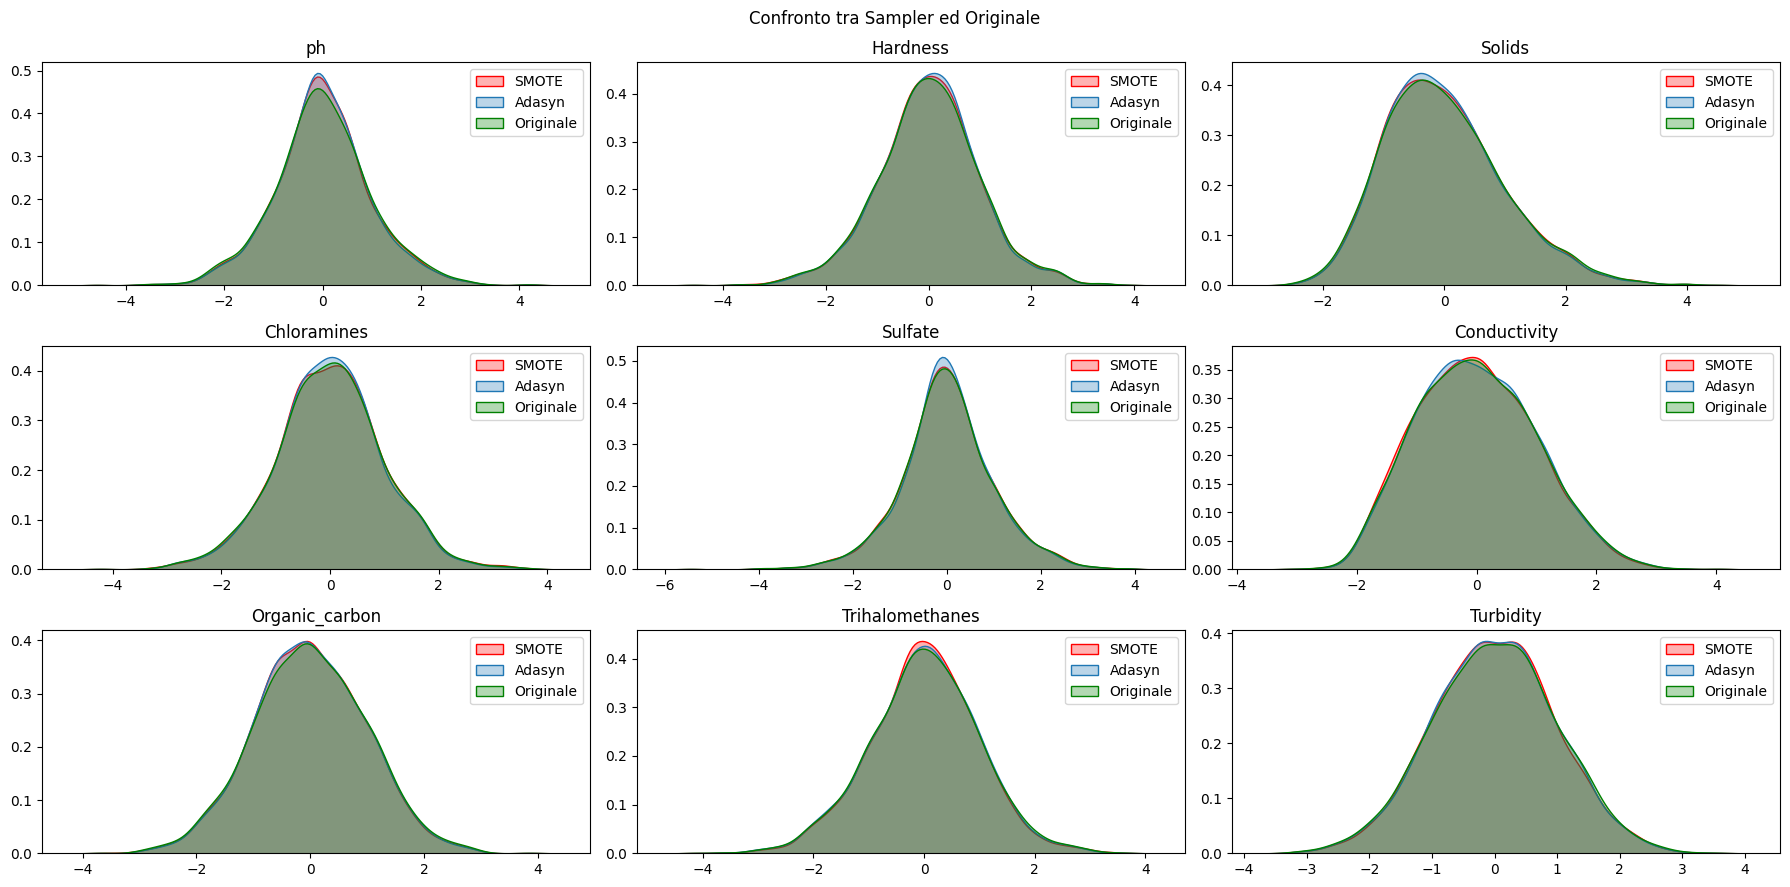

In [45]:
fig, ax = plt.subplots(3,3, figsize=(18,9))
ax=ax.ravel()

for i, col in enumerate(df_smte.columns[:-1]):

    sns.kdeplot(df_smte[col], fill=True, label='SMOTE', ax=ax[i], color='red', alpha=0.3,linewidth=1)
    sns.kdeplot(df_ada[col], label='Adasyn', fill=True, ax=ax[i], alpha=0.3,linewidth=1)
    sns.kdeplot(w_scaled[col], label='Originale', fill=True, ax=ax[i], color='green', alpha=0.3,linewidth=1)
    ax[i].set_title(f"{col}")
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].legend()

plt.suptitle("Confronto tra Sampler ed Originale")
plt.tight_layout()
plt.show()

Come leggere questo grafico:
ho voluto riportare graficamente i valori _originali_ e _dopo resampling_ per evidenziare eventuali cambiamenti nelle distribuzioni. Nei grafici in cui si nota il colore rosso, vuol dire che __SMOTE__ in quel punto potrebbe aver generato dei
dati non perfettamente congrui al dataset originale; lo stesso vale per ADASYN nei segmenti azzurri. <br>
SMOTE sembra generare dei campioni tali da rendere la distribuzione più aderente all'originale rispetto ad ADASYN; per questo motivo impiegherò SMOTE come tecnica di resampling.

Con la EDA di sopra, si sono notate alcune peculiarità sul dataset. Attraverso sperimentazione di diverse pratiche, delineo il percorso che mi è sembrato ottimale:
1. Dividere in train e test il dataset;
2. Imputazione dei dati mancanti con KNN Imputer;
3. Standardizzazione dei dati;
4. Bilanciamento del training set usando SMOTE.

 
Tutti questi passaggi possono essere inseriti all'interno di una _pipeline_, ovvero un metodo specifico di sklearn, che crea (come intuibile) una pipeline ovvero una sequenza di processi.


Tra qualche cella sarà inoltre necessario ricorrere ai dati di test: a questi dovrò applicare lo 'scaler' e l'imputer creati prima, ovvero addestrati __esclusivamente__ sul training set: in questo modo evito che le informazioni contenute nel test set vengano impiegate per una funzione che non sia quella della valutazione (_data leakage_).

## Machine Learning

### scelta della metrica: Accuracy e non solo

La __Accuracy__ indica quante delle predizioni effettuate sono corrette: è un'indice piuttosto semplice che non spiega granché sul modello, se non la performance nel modo più intuitivo possibile. <br>

Oltre l'accuracy, alcune metriche consentono invece un approfondimento sul come vengono effettuate le predizioni, ovvero se alcune classi sono più facili di altre da predire, o se il modello tende a 'sovra-predire' alcune classi.

Ad esempio la __Recall__ misura la abilità del modello di identificare correttamente tutti i _True Positives_ all'interno del dataset; la __Precision__ indica invece quanti dei positivi dichiarati dal modello sono effettivamente tali: se l'obbiettivo fosse ridurre  al minimo i _Falsi Positivi_ (ovvero l'acqua non potabile etichettata, per errore, come potabile), la __Precision__ sarebbe la metrica più consigliata. <br>

Un modello che tende a predire con troppa facilità _Positivo_, avrà un punteggio __Recall__ pari a 1 (ovvero perfetto) ma logicamente ne risentirà la __Precision__; per rimediare a questo trade-off, spesso è opportuno calcolare __F1-Score__, ovvero la media armonizzata tra le due metriche precedentemente descritte. 

Sempre in ambito _Classificazione_ rientra la ROC AUC, ovvero la __Receiver Operating Characteristic - Area Under the Curve__. <br>
Questa mostra il cambiamento del _Recall_ e _FPR_ (False Positive Rate) variando la soglia di decisione; come intuibile da quanto scritto prima, tra Recall ed FPR vi è un vero e proprio trade-off.
maggiore è l'area sottesa alla curva (AUC), migliore sarà la performance del modello. 

Tra le tante metriche non ce n'è una inequivocabilmente meglio delle altre, la scelta è subordinata alla natura del problema e alla destinazione d'uso. 
L'unica circostanza in cui si è certi della bontà del modello sarebbe quella in cui la accuracy fosse pari a 1; tuttavia, questo risultato in fase di training sarebbe un verosimile segnale di overfitting.

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, roc_curve, auc, roc_auc_score, fbeta_score, make_scorer, precision_score,
                            confusion_matrix, ConfusionMatrixDisplay,
                            classification_report)

from sklearn.model_selection import (StratifiedKFold,
                                    RepeatedStratifiedKFold, 
                                    cross_val_score, 
                                    GridSearchCV)

from sklearn.pipeline import Pipeline

Per pulizia nel procedimento, reinizializzo tutto costruendo però una piccola pipeline per il preprocessing.

In [47]:
water_df = pd.read_csv("water_potability.csv")

X = water_df.drop('Potability',axis=1)
y = water_df["Potability"]


X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8,
                                                   random_state=SEED,
                                                   stratify=y)


# elimino righe con 3 valori mancanti SOLO dal training set
df_train = pd.concat([X_train, y_train], axis=1)
df_train = df_train[df_train.isnull().sum(axis=1) < 3]

# shufflati, indici mixati

prep_pipeline = Pipeline([
    ('imputer', KNNImputer()),
    ('scaler', StandardScaler())
])


# ri-chiamo X_train ed y_train, senza le righe eliminate prima
X_train = df_train.drop('Potability', axis=1)
y_train = df_train['Potability']

X_train_transformed = prep_pipeline.fit_transform(X_train)
X_train = pd.DataFrame(X_train_transformed, columns=X.columns, index=X_train.index) # assegno indice per poi concatenare con y_train

X_test_transformed = prep_pipeline.transform(X_test)
X_test = pd.DataFrame(X_test_transformed, columns=X.columns, index=X_test.index)

training_set = pd.concat([X_train, y_train], axis=1).reset_index().drop('index',axis=1)

### Baseline Model

Quando si è interessati alla costruzione di un modello predittivo, è bene stabilire un 'baseline model' preliminare che faccia da riferimento minimo per le prestazioni ottenute. <br>
Non tutti i problemi infatti sono risolvibili efficacemente con algoritmi: a volte, il problema è talmente complesso che una soluzione basata sulla casualità o assegnazione di valori secondo logiche molto elementari potrebbe essere pari o addirittura superiore a quelle garantite da modelli sofisticati. 

In altre parole, il ricorso ai modelli di Machine Learning deve essere concepito come opportunità e non come attività tassativa.

In [48]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

print("Baseline model (Most Frequent Class):")
print(classification_report(y_test, dummy_clf.predict(X_test), zero_division=np.nan))

Baseline model (Most Frequent Class):
              precision    recall  f1-score   support

           0       0.61      1.00      0.76       400
           1        nan      0.00      0.00       256

    accuracy                           0.61       656
   macro avg       0.61      0.50      0.38       656
weighted avg       0.61      0.61      0.46       656



In [49]:
dummy_clf_random = DummyClassifier(strategy="stratified", random_state=42)
dummy_clf_random.fit(X_train, y_train)

print("Baseline model (Random Predictions):")
print(classification_report(y_test,  dummy_clf_random.predict(X_test)))

Baseline model (Random Predictions):
              precision    recall  f1-score   support

           0       0.60      0.59      0.59       400
           1       0.37      0.38      0.37       256

    accuracy                           0.51       656
   macro avg       0.48      0.48      0.48       656
weighted avg       0.51      0.51      0.51       656



Un classificatore modale ottiene il 61% di accuracy: niente di sorprendente, essendo quella la proporzione tra le classi. <br>

Il classificatore 'ponderato' ottiene invece una accuracy del 51%, praticamente una su due. 

Se considerassimo tutta l'acqua come non potabile (come fa il primo class.), non ci sarebbe alcun bisogno di procedere con ulteriori sviluppi. Di per sé, mal-classificare l'acqua potabile in non-potabile non avrebbe conseguenze drammatiche per la salute (a dispetto di quanto accadrebbe viceversa), tuttavia è bene ricordare che l'acqua è un bene estremamente prezioso e sarebbe auspicabile costruire un modello in grado di stabilire correttamente tutte le etichette, in modo da non sprecare acqua potabile. 

Alla luce di ciò, prenderò in considerazione il secondo classificatore come baseline model di riferimento e come richiesto dal progetto impiegherò la __Accuracy__ per valutare la bontà dei modelli, dando comunque peso anche alla Precision in classe 1.

### Tutte le features

#### Spot check

In [50]:
resampls = {'ADASYN':ADASYN(sampling_strategy=0.85, random_state=SEED),
            'SMOTE':SMOTE(sampling_strategy=0.75, random_state=SEED)}

models = {
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=SEED),
    'Logistic Regression': LogisticRegression(random_state=SEED, class_weight='balanced'),
    'dummy - random' : DummyClassifier(strategy="stratified", random_state=SEED)

}
best_models = []

rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=SEED)

def balancing_spot_check(dataset, resampling_dict, modelli_dict, cv=rskf, scoring='accuracy'):
    '''
    Funzione che prende in argomento il set di addestramento, due dizionari: 'modelli' e 'resampling', devono contenere nome e tecnica impiegata;
    la ripartizione dei fold per la cross_validation;
    in output piccolo recap delle validazioni e boxplot risultati.
    '''

    global best_model_1, best_model_2
    
    xtrain = dataset.iloc[:, :-1]
    ytrain = dataset.iloc[:, -1]

    risultati = []
    

    score_name = scoring

    for nome, modo in resampling_dict.items():
        X_new, y_new = modo.fit_resample(xtrain, ytrain)
        
        print('Resampling:', nome, Counter(y_new))
        print('')
        for name, model in modelli_dict.items():
            cv_scores = cross_val_score(model, cv=cv, X=X_new, y=y_new, scoring=scoring)
            print(f'Risultati {name} con {nome}: {cv_scores.mean():.3f} ± {cv_scores.std():.4f}')
            for score_value in cv_scores:
                risultati.append({
                    'Model': name,
                    'Tecnica di Resampling': nome,
                    score_name: score_value,
                    'Istanza': model
                })
        print('______________________________________________________________')
    
    print('No resampling:')
    for name, model in modelli_dict.items():
        cv_scores = cross_val_score(model, cv=cv, X=xtrain, y=ytrain, scoring=scoring)
        print(f'Risultati {name} senza resampling: {cv_scores.mean():.3f} ± {cv_scores.std():.4f}')
        for score_value in cv_scores:
            risultati.append({
                'Model': name,
                'Tecnica di Resampling': 'No resample',
                score_name: score_value
            })
            
        best_models.append({
            'Model': name,
            'Istance': model,
            'Score': cv_scores.mean()
        })
    
    best_model_1 = pd.DataFrame(best_models).sort_values(by='Score', ascending=False)['Istance'].iloc[0]
    best_model_2 = pd.DataFrame(best_models).sort_values(by='Score', ascending=False)['Istance'].iloc[1]
    
    df_results = pd.DataFrame(risultati)
    
    unique_resampling = df_results['Tecnica di Resampling'].unique()
    num_resampling = len(unique_resampling)

    fig, axes = plt.subplots(1, num_resampling, figsize=(6 * num_resampling, 6), sharey=True)

    if num_resampling == 1:
        axes = [axes] 

    for idx, resampling in enumerate(unique_resampling):
        ax = axes[idx]
        data = df_results[df_results['Tecnica di Resampling'] == resampling]
        sns.boxplot(x="Model", y=score_name, data=data, ax=ax)
        ax.set_title(resampling)
        ax.set_ylabel(scoring)
        ax.set_xlabel('')
        ax.grid(True)

    fig.suptitle('Confronto tra modelli su diverse tecniche di resampling', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    print('Salvati come "best_model_1" e "best_model_2"')
    return best_model_1, best_model_2


Resampling: ADASYN Counter({0: 1591, 1: 1107})

Risultati KNN con ADASYN: 0.608 ± 0.0263
Risultati Random Forest con ADASYN: 0.672 ± 0.0257
Risultati Logistic Regression con ADASYN: 0.494 ± 0.0297
Risultati dummy - random con ADASYN: 0.514 ± 0.0256
______________________________________________________________
Resampling: SMOTE Counter({0: 1591, 1: 1193})

Risultati KNN con SMOTE: 0.649 ± 0.0210
Risultati Random Forest con SMOTE: 0.703 ± 0.0316
Risultati Logistic Regression con SMOTE: 0.492 ± 0.0291
Risultati dummy - random con SMOTE: 0.521 ± 0.0282
______________________________________________________________
No resampling:
Risultati KNN senza resampling: 0.638 ± 0.0317
Risultati Random Forest senza resampling: 0.670 ± 0.0220
Risultati Logistic Regression senza resampling: 0.484 ± 0.0238
Risultati dummy - random senza resampling: 0.530 ± 0.0330


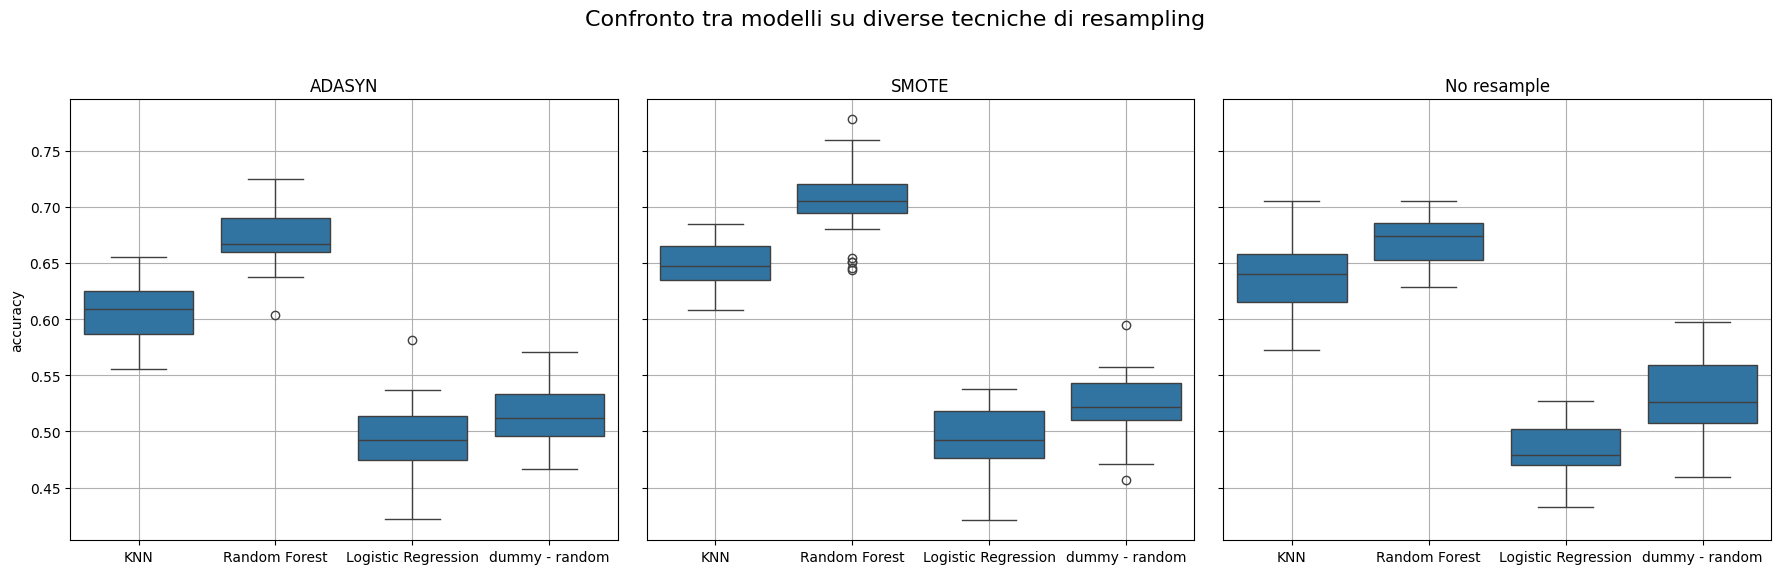

Salvati come "best_model_1" e "best_model_2"


(RandomForestClassifier(random_state=42), KNeighborsClassifier())

In [51]:
balancing_spot_check(dataset=training_set, modelli_dict=models, resampling_dict=resampls)

- Le _sampling strategies_ sono leggermente diverse tra loro perché ADASYN richiedeva un numero più grande;
- In tutti i casi, KNN e RF performano meglio tra tutti;
- I modelli creati con ADASYN e SMOTE sono molto simili al No Resample, tuttavia SMOTE sembra favorire maggior robustezza dei modelli sebbene alcuni punteggi siano outlier;

Date le considerazioni sopra, procederò utilizzando un training set con oversampling di SMOTE.

In [52]:
best_model_1

RandomForestClassifier(random_state=42)

In [53]:
best_model_2

KNeighborsClassifier()

In [54]:
smote = SMOTE(sampling_strategy=0.75, random_state=42)
X_smt, y_smt = smote.fit_resample(X_train, y_train)
Counter(y_smt)

Counter({0: 1591, 1: 1193})

La "sampling strategy" permette di definire ex-ante la proporzione tra classe minoritaria e maggioritaria: essendo il punto di partenza circa 0.6, ho optato per 0.75 per evitare che venissero creati troppi campioni sintetici.
<br>In questo caso, la classe minoritaria aumenta del 16% circa.

#### Grid Search

Nelle celle seguenti, impiegherò una Grid Search per trovare i migliori iperparametri possibili per i due algoritmi emersi come migliori dallo spot check precedente (RF e KNN);

la funzione di sotto permette di eseguire la Grid Search secondo le combinazioni che mi interessa sperimentare: 
- Oversampling Sì/No
- Feature Selection: Sì/No; userò Mutual Information;


Alla fine, avrò quattro istanze per ciascun modello, secondo la logica descritta sopra. Tutti i risultati verranno immagazzinati in una lista "__grid_models__"  trasformabile in dataframe per agevolare la visualizzazione e l'analisi.

In [55]:
grid_models = []

import time
from sklearn.utils import all_estimators

skf = StratifiedKFold(n_splits=10)

def grid_scores(model, params_grid, x=X_train, y=y_train, scoring='accuracy', feature_sel='no', oversampling=None):
    '''
    funzione per effettuare una grid search; gli args sono il modello scelto, la griglia di parametri corrispondente; opzionali X ed y,
    la metrica di score (default = accuracy); come cross-val una stratifiedkfold; feature_selection e oversampling aggiungibili, default: No
    '''

    model_name_dict = {est[0]: est[1].__name__ for est in all_estimators()}

    grid_model = GridSearchCV(estimator=model,
                             param_grid=params_grid,
                             scoring=scoring,
                             cv=skf,
                             n_jobs=5)

    
    if feature_sel == 'anova':
        print('ANOVA per feature selection, k=4')
        anova_selector = SelectKBest(f_classif, k=4)
        X_kbest = anova_selector.fit_transform(X_train, y_train)
        x = X_kbest
        selected_feats = X_train.columns[anova_selector.get_support()]
        print(f"Colonne selezionate: {list(selected_feats)}")
        
    elif feature_sel == 'mi':
        global feat_sel 
        print('Mutual Information: prime 3 features')
      
        mi_scores = mutual_info_classif(x, y, random_state=42)
        mi_scores_series = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)
        features_mi = mi_scores_series.nlargest(3).index.tolist()
        x = x[features_mi]
        print(f"Colonne scelte: {features_mi}")
        
    if oversampling == 'smote':
        smote = SMOTE(sampling_strategy=0.75, random_state=42)
        x, y = smote.fit_resample(x, y)
        print(Counter(y))
     
    start_time_grid = time.time()
    grid_model.fit(x, y)
    end_time_grid = time.time()
    grid_time = end_time_grid - start_time_grid
    
    model_name = model_name_dict.get(type(model).__name__, type(model).__name__)
    best_model = grid_model.best_estimator_
    best_score = grid_model.best_score_
    best_index = grid_model.best_index_
    std_dev = grid_model.cv_results_['std_test_score'][best_index]

    start_time_model = time.time()
    best_model.fit(x, y)
    end_time_model = time.time()
    model_time = end_time_model - start_time_model
    
    precision = precision_score(y, best_model.predict(x), pos_label=1)

    print(x.shape)

    grid_models.append({
       'Model Name': model_name,
       'Modello': best_model,
       'Oversampling': oversampling,
       'Feature Selection': feature_sel,  
       f'Media punteggio({scoring})': best_score,
       f'Dev STD punteggio({scoring})': std_dev,
       'Precision score': precision,
       'GridSearch Time (s)': grid_time,
       'Model Training Time (s)': model_time
        })
    
    print(f"""
Migliori parametri: {best_model}, 
Punteggio medio ({scoring}): {best_score:.4f} ± {std_dev:.4f}
""")
    

In [56]:
params_knn = {
    'n_neighbors': list(np.arange(3, 21, 2)),
    'weights': ('uniform','distance'),
    'metric':('euclidean', 'manhattan','minkowski'),
}

knn = KNeighborsClassifier()
grid_scores(knn, params_knn, oversampling='smote')

Counter({0: 1591, 1: 1193})
(2784, 9)

Migliori parametri: KNeighborsClassifier(metric='euclidean', n_neighbors=17, weights='distance'), 
Punteggio medio (accuracy): 0.6771 ± 0.0461



In [57]:
params_knn = {
    'n_neighbors': list(np.arange(3, 21, 2)),
    'weights': ('uniform','distance'),
    'metric':('euclidean', 'manhattan','minkowski'),
}

knn = KNeighborsClassifier()
grid_scores(knn, params_knn)

(2612, 9)

Migliori parametri: KNeighborsClassifier(metric='euclidean', n_neighbors=19), 
Punteggio medio (accuracy): 0.6497 ± 0.0159



In [58]:
pd.DataFrame(grid_models)

,Model Name,Modello,Oversampling,Feature Selection,Media punteggio(accuracy),Dev STD punteggio(accuracy),Precision score,GridSearch Time (s),Model Training Time (s)
0,KNeighborsClassifier,"KNeighborsClassifier(metric='euclidean', n_nei...",smote,no,0.677129,0.046080,1.000000,4.472506,0.005002
1,KNeighborsClassifier,"KNeighborsClassifier(metric='euclidean', n_nei...",None,no,0.649681,0.015877,0.708075,2.573872,0.005002


In [59]:
rf = RandomForestClassifier(random_state=42)
params_rf = {
   'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [None, 3, 5, 7],  
    'min_samples_split': [2, 3, 5, 7], 
    'min_samples_leaf': [2, 4, 6],    
    'criterion':('gini', 'entropy')}

grid_scores(rf, params_rf, oversampling='smote')

Counter({0: 1591, 1: 1193})
(2784, 9)

Migliori parametri: RandomForestClassifier(min_samples_leaf=2, n_estimators=200, random_state=42), 
Punteggio medio (accuracy): 0.7008 ± 0.0314



In [60]:
rf = RandomForestClassifier(random_state=42)
params_rf = {
   'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [None, 3, 5, 7],  
    'min_samples_split': [2, 3, 5, 7], 
    'min_samples_leaf': [2, 4, 6],    
    'criterion':('gini', 'entropy')}

grid_scores(rf, params_rf)

(2612, 9)

Migliori parametri: RandomForestClassifier(min_samples_leaf=2, n_estimators=200, random_state=42), 
Punteggio medio (accuracy): 0.6723 ± 0.0141



### Feature Selection

#### Spot Check

features scelte: ['Sulfate', 'Hardness', 'ph'] 


Resampling: ADASYN Counter({0: 1591, 1: 1125})

Risultati KNN con ADASYN: 0.580 ± 0.0223
Risultati Random Forest con ADASYN: 0.625 ± 0.0290
Risultati Logistic Regression con ADASYN: 0.490 ± 0.0270
Risultati dummy - random con ADASYN: 0.530 ± 0.0255
______________________________________________________________
Resampling: SMOTE Counter({0: 1591, 1: 1193})

Risultati KNN con SMOTE: 0.625 ± 0.0247
Risultati Random Forest con SMOTE: 0.660 ± 0.0257
Risultati Logistic Regression con SMOTE: 0.492 ± 0.0258
Risultati dummy - random con SMOTE: 0.521 ± 0.0282
______________________________________________________________
No resampling:
Risultati KNN senza resampling: 0.613 ± 0.0220
Risultati Random Forest senza resampling: 0.645 ± 0.0225
Risultati Logistic Regression senza resampling: 0.492 ± 0.0313
Risultati dummy - random senza resampling: 0.530 ± 0.0330


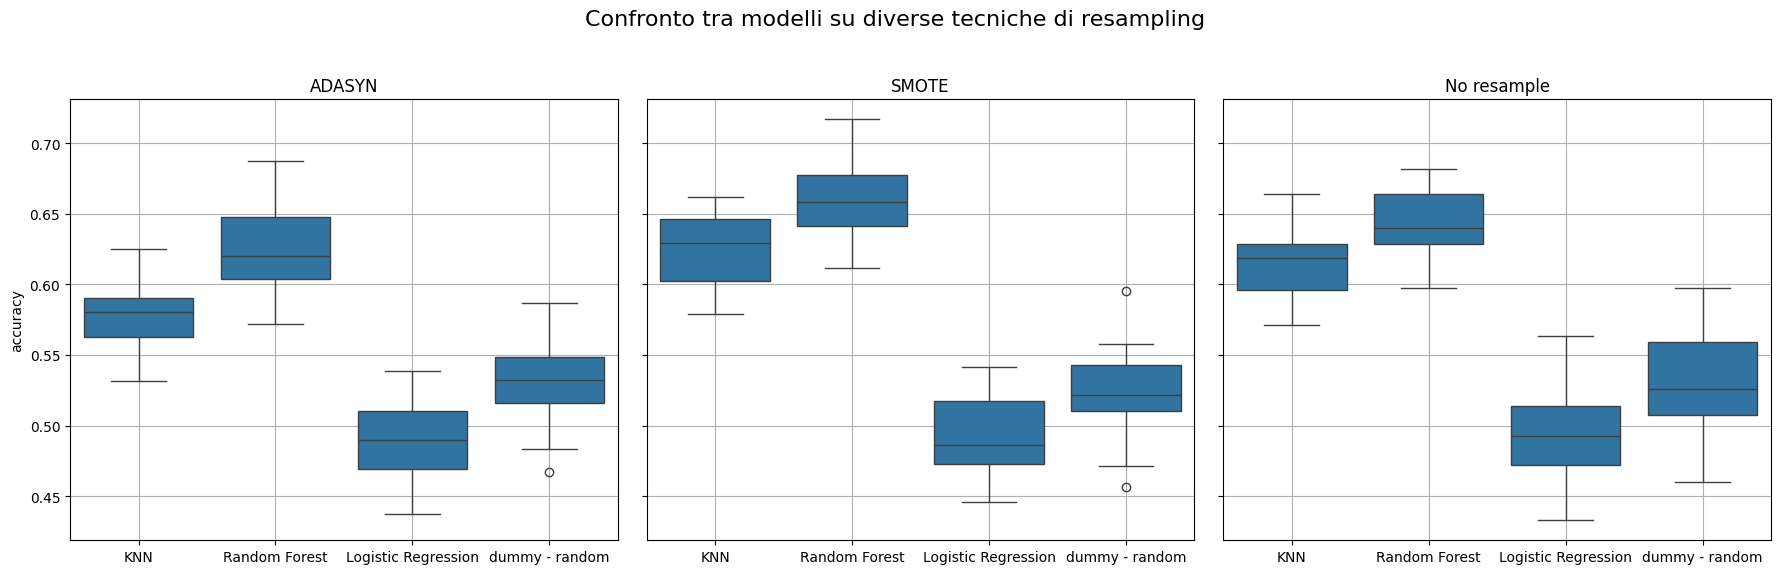

Salvati come "best_model_1" e "best_model_2"


(RandomForestClassifier(random_state=42),
 RandomForestClassifier(random_state=42))

In [61]:
resampls = {'ADASYN':ADASYN(sampling_strategy=0.85, random_state=42),
            'SMOTE':SMOTE(sampling_strategy=0.75, random_state=42)}

models = {
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42,class_weight='balanced'),
    'dummy - random' : DummyClassifier(strategy="stratified", random_state=42)

}

X_feats = X_train[features_mi]
df_selected = pd.concat([X_feats, y_train],axis=1)

print('features scelte:', features_mi, '\n\n')
balancing_spot_check(dataset=df_selected, resampling_dict=resampls, modelli_dict=models)

Anche in questo caso, SMOTE sembra quello più robusto. I risultati sono comunque peggiori rispetto all'impiego di tutte le feature nel dataset; anche il RandomForest a sua volta sottolineò l'importanza molto distribuita in tutte le feats.

#### Grid Search

In [62]:
params_knn = {
    'n_neighbors': list(np.arange(3, 21, 2)),
    'weights': ('uniform','distance'),
    'metric':('euclidean', 'manhattan','minkowski'),
}

knn = KNeighborsClassifier()
grid_scores(knn, params_knn, oversampling='smote',feature_sel='mi')

Mutual Information: prime 3 features
Colonne scelte: ['Sulfate', 'Hardness', 'ph']
Counter({0: 1591, 1: 1193})
(2784, 3)

Migliori parametri: KNeighborsClassifier(metric='euclidean', n_neighbors=17, weights='distance'), 
Punteggio medio (accuracy): 0.6688 ± 0.0317



In [63]:
knn = KNeighborsClassifier()
grid_scores(knn, params_knn, feature_sel='mi')

Mutual Information: prime 3 features
Colonne scelte: ['Sulfate', 'Hardness', 'ph']
(2612, 3)

Migliori parametri: KNeighborsClassifier(metric='euclidean', n_neighbors=19), 
Punteggio medio (accuracy): 0.6600 ± 0.0167



In [64]:
rf = RandomForestClassifier(random_state=42)
params_rf = {
   'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [None, 3, 5, 7],  
    'min_samples_split': [2, 3, 5, 7], 
    'min_samples_leaf': [2, 4, 6],    
    'criterion':('gini', 'entropy')}


grid_scores(rf, params_rf, oversampling='smote', feature_sel='mi')

Mutual Information: prime 3 features
Colonne scelte: ['Sulfate', 'Hardness', 'ph']
Counter({0: 1591, 1: 1193})
(2784, 3)

Migliori parametri: RandomForestClassifier(min_samples_leaf=2, n_estimators=250, random_state=42), 
Punteggio medio (accuracy): 0.6584 ± 0.0204



In [65]:
rf = RandomForestClassifier(random_state=42)

grid_scores(rf, params_rf, feature_sel='mi')

Mutual Information: prime 3 features
Colonne scelte: ['Sulfate', 'Hardness', 'ph']
(2612, 3)

Migliori parametri: RandomForestClassifier(criterion='entropy', min_samples_leaf=6,
                       n_estimators=250, random_state=42), 
Punteggio medio (accuracy): 0.6574 ± 0.0150



### Analisi dei risultati ottenuti

In [66]:
grids_df = pd.DataFrame(grid_models)
grids_df['Valore minimo atteso'] = grids_df['Media punteggio(accuracy)'] - grids_df['Dev STD punteggio(accuracy)']
grids_df['Oversampling'] = grids_df['Oversampling'].fillna('No')
grids_df['Oversampling'] = grids_df['Oversampling'].astype('category')

In [67]:
grids_df.sort_values(by='Valore minimo atteso', ascending=False)

,Model Name,Modello,Oversampling,Feature Selection,Media punteggio(accuracy),Dev STD punteggio(accuracy),Precision score,GridSearch Time (s),Model Training Time (s),Valore minimo atteso
2,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', m...",smote,no,0.700820,0.031371,1.000000,954.616074,1.791405,0.669449
3,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', m...",No,no,0.672275,0.014074,1.000000,896.525599,1.766953,0.658201
5,KNeighborsClassifier,"KNeighborsClassifier(metric='euclidean', n_nei...",No,mi,0.660030,0.016677,0.690252,1.540348,0.003000,0.643354
7,RandomForestClassifier,"(DecisionTreeClassifier(criterion='entropy', m...",No,mi,0.657359,0.014960,0.898072,476.529006,1.203276,0.642399
6,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', m...",smote,mi,0.658429,0.020432,0.990678,500.722977,1.109279,0.637998
4,KNeighborsClassifier,"KNeighborsClassifier(metric='euclidean', n_nei...",smote,mi,0.668848,0.031744,1.000000,1.484335,0.002001,0.637105
1,KNeighborsClassifier,"KNeighborsClassifier(metric='euclidean', n_nei...",No,no,0.649681,0.015877,0.708075,2.573872,0.005002,0.633804
0,KNeighborsClassifier,"KNeighborsClassifier(metric='euclidean', n_nei...",smote,no,0.677129,0.046080,1.000000,4.472506,0.005002,0.631050


In [68]:
grids_df['Accuracy_Test'] = np.nan
grids_df['Precision_ 1_Test'] = np.nan
grids_df['Prediction Time (s)'] = np.nan

In [69]:
grids_df_all_feats = grids_df.loc[grids_df["Feature Selection"] == 'no']
grids_df_sel_feats = grids_df.loc[grids_df["Feature Selection"] == 'mi']

In [70]:
grids_df_all_feats

,Model Name,Modello,Oversampling,Feature Selection,Media punteggio(accuracy),Dev STD punteggio(accuracy),Precision score,GridSearch Time (s),Model Training Time (s),Valore minimo atteso,Accuracy_Test,Precision_ 1_Test,Prediction Time (s)
0,KNeighborsClassifier,"KNeighborsClassifier(metric='euclidean', n_nei...",smote,no,0.677129,0.046080,1.000000,4.472506,0.005002,0.631050,NaN,NaN,NaN
1,KNeighborsClassifier,"KNeighborsClassifier(metric='euclidean', n_nei...",No,no,0.649681,0.015877,0.708075,2.573872,0.005002,0.633804,NaN,NaN,NaN
2,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', m...",smote,no,0.700820,0.031371,1.000000,954.616074,1.791405,0.669449,NaN,NaN,NaN
3,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', m...",No,no,0.672275,0.014074,1.000000,896.525599,1.766953,0.658201,NaN,NaN,NaN


Ora si hanno a disposizione due piccoli dataframe, riassuntivi dei modelli validati e col rispettivo punteggio. 

In [71]:
grids_df.to_csv('df_modelli_ML.csv', index=False) # salvataggio df

Quanto incide l'oversampling nel punteggio (accuracy)?

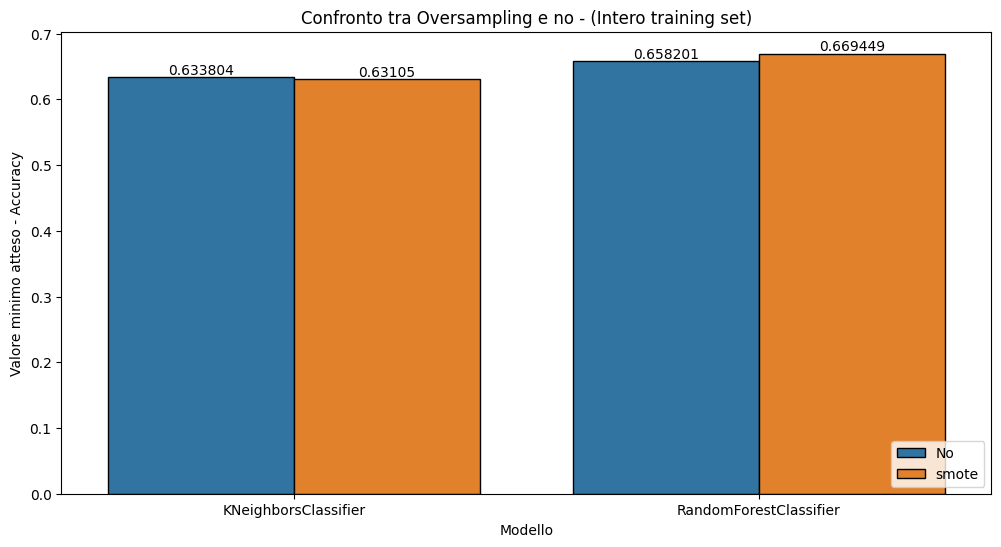

In [72]:
fig, ax = plt.subplots(figsize=(12,6))

ax = sns.barplot(data=grids_df_all_feats, x='Model Name', y='Valore minimo atteso', hue='Oversampling', edgecolor='k')

for i in ax.containers:
    ax.bar_label(i,)
    
ax.set_title('Confronto tra Oversampling e no - (Intero training set)')
ax.set_xlabel("Modello")
ax.set_ylabel("Valore minimo atteso - Accuracy")
plt.legend(loc='lower right')
plt.show()

Si tenga conto che ciascuna delle due barre per ognuno dei due modelli rappresenta un'istanza diversa dello stesso modello: vale a dire, iperparametri diversi, ma comunque ottimali secondo la GridSearch per i dati a esso sottoposto.
<br> Vuole essere un modo per mostrare la potenzialità dei modelli con o senza SMOTE.

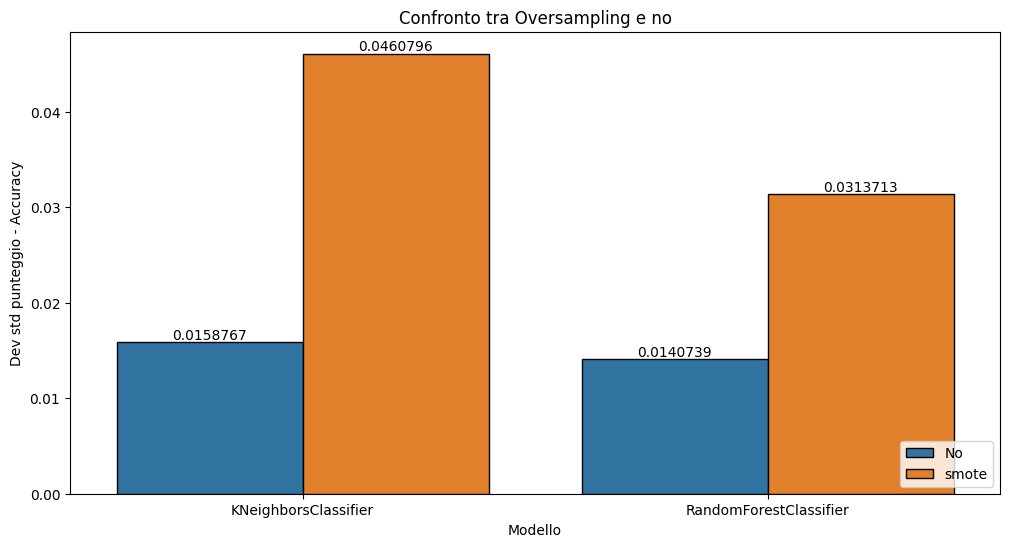

In [73]:
fig, ax = plt.subplots(figsize=(12,6))

sns.barplot(data=grids_df_all_feats, x='Model Name', y='Dev STD punteggio(accuracy)', hue='Oversampling', edgecolor='k')

for i in ax.containers:
    ax.bar_label(i,)

ax.set_title('Confronto tra Oversampling e no')
ax.set_xlabel("Modello")
ax.set_ylabel("Dev std punteggio - Accuracy")
plt.legend(loc='lower right')
plt.show()

Nella cross-validation con SMOTE, notiamo una deviazione standard molto più alta rispetto al non-oversampling; è possibile che SMOTE abbia inserito del 'rumore' nel dataset e questo è foriero di overfitting per i modelli.

### Previsioni del Modello: confronto sul Test Set

#### Tutte le features

In [74]:
grids_df_all_feats

,Model Name,Modello,Oversampling,Feature Selection,Media punteggio(accuracy),Dev STD punteggio(accuracy),Precision score,GridSearch Time (s),Model Training Time (s),Valore minimo atteso,Accuracy_Test,Precision_ 1_Test,Prediction Time (s)
0,KNeighborsClassifier,"KNeighborsClassifier(metric='euclidean', n_nei...",smote,no,0.677129,0.046080,1.000000,4.472506,0.005002,0.631050,NaN,NaN,NaN
1,KNeighborsClassifier,"KNeighborsClassifier(metric='euclidean', n_nei...",No,no,0.649681,0.015877,0.708075,2.573872,0.005002,0.633804,NaN,NaN,NaN
2,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', m...",smote,no,0.700820,0.031371,1.000000,954.616074,1.791405,0.669449,NaN,NaN,NaN
3,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', m...",No,no,0.672275,0.014074,1.000000,896.525599,1.766953,0.658201,NaN,NaN,NaN


In [75]:
for idx, row in grids_df_all_feats.iterrows():
    model_name = row['Model Name']  
    model = row['Modello']  
    oversampling = row['Oversampling']
    print(f'\nModello: {model_name}, Oversampling: {oversampling}')

    start_time_pred = time.time()
    predictions = model.predict(X_test)
    end_time_pred = time.time()
    pred_time = end_time_pred - start_time_pred
    print('')
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='binary', pos_label=1)

    grids_df_all_feats.at[idx, 'Accuracy_Test'] = accuracy
    grids_df_all_feats.at[idx, 'Precision_ 1_Test'] = precision
    grids_df_all_feats.at[idx, 'Prediction Time (s)'] = pred_time

    
    print(f'Accuracy del modello: {accuracy:.4f}\n')
    print(f'Precisione (classe 1) del modello: {precision:.4f}\n')

    print('_____________________________________________________')


Modello: KNeighborsClassifier, Oversampling: smote

Accuracy del modello: 0.6113

Precisione (classe 1) del modello: 0.5029

_____________________________________________________

Modello: KNeighborsClassifier, Oversampling: No

Accuracy del modello: 0.6280

Precisione (classe 1) del modello: 0.5600

_____________________________________________________

Modello: RandomForestClassifier, Oversampling: smote

Accuracy del modello: 0.6509

Precisione (classe 1) del modello: 0.5839

_____________________________________________________

Modello: RandomForestClassifier, Oversampling: No

Accuracy del modello: 0.6616

Precisione (classe 1) del modello: 0.6417

_____________________________________________________


In [76]:
best_model_all = grids_df_all_feats.sort_values(by='Accuracy_Test', ascending=False)['Modello'].iloc[0]
print("Miglior modello con tutte le feature:")
grids_df_all_feats.sort_values(by='Accuracy_Test', ascending=False).iloc[[0]]

Miglior modello con tutte le feature:


,Model Name,Modello,Oversampling,Feature Selection,Media punteggio(accuracy),Dev STD punteggio(accuracy),Precision score,GridSearch Time (s),Model Training Time (s),Valore minimo atteso,Accuracy_Test,Precision_ 1_Test,Prediction Time (s)
3,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', m...",No,no,0.672275,0.014074,1.0,896.525599,1.766953,0.658201,0.661585,0.641667,0.033007


Il Random Forest senza Oversampling è il modello che ottiene un punteggio migliore nella Accuracy e Precisione nella classe 1 

#### Feature Selection

In [77]:
grids_df_sel_feats.sort_values(by='Valore minimo atteso')

,Model Name,Modello,Oversampling,Feature Selection,Media punteggio(accuracy),Dev STD punteggio(accuracy),Precision score,GridSearch Time (s),Model Training Time (s),Valore minimo atteso,Accuracy_Test,Precision_ 1_Test,Prediction Time (s)
4,KNeighborsClassifier,"KNeighborsClassifier(metric='euclidean', n_nei...",smote,mi,0.668848,0.031744,1.000000,1.484335,0.002001,0.637105,NaN,NaN,NaN
6,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', m...",smote,mi,0.658429,0.020432,0.990678,500.722977,1.109279,0.637998,NaN,NaN,NaN
7,RandomForestClassifier,"(DecisionTreeClassifier(criterion='entropy', m...",No,mi,0.657359,0.014960,0.898072,476.529006,1.203276,0.642399,NaN,NaN,NaN
5,KNeighborsClassifier,"KNeighborsClassifier(metric='euclidean', n_nei...",No,mi,0.660030,0.016677,0.690252,1.540348,0.003000,0.643354,NaN,NaN,NaN


In [78]:
for idx, row in grids_df_sel_feats.iterrows():
    model_name = row['Model Name']  
    model = row['Modello']  
    oversampling = row['Oversampling']
    print(f'\nModello: {model_name}, Oversampling: {oversampling}')


    start_time_pred = time.time()
    predictions = model.predict(X_test[features_mi])
    end_time_pred = time.time()
    pred_time = end_time_pred - start_time_pred
    
    print('')
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='binary', pos_label=1)

    grids_df_sel_feats.at[idx, 'Accuracy_Test'] = accuracy
    grids_df_sel_feats.at[idx, 'Precision_ 1_Test'] = precision
    grids_df_sel_feats.at[idx, 'Prediction Time (s)'] = pred_time
    
    print(f'Accuracy del modello: {accuracy:.4f}\n')
    print(f'Precisione (classe 1) del modello: {precision:.4f}\n')

    print('_____________________________________________________')


Modello: KNeighborsClassifier, Oversampling: smote

Accuracy del modello: 0.6235

Precisione (classe 1) del modello: 0.5205

_____________________________________________________

Modello: KNeighborsClassifier, Oversampling: No

Accuracy del modello: 0.6540

Precisione (classe 1) del modello: 0.5890

_____________________________________________________

Modello: RandomForestClassifier, Oversampling: smote

Accuracy del modello: 0.6524

Precisione (classe 1) del modello: 0.5761

_____________________________________________________

Modello: RandomForestClassifier, Oversampling: No

Accuracy del modello: 0.6524

Precisione (classe 1) del modello: 0.5946

_____________________________________________________


In [79]:
best_model_sel = grids_df_sel_feats.sort_values(by='Accuracy_Test', ascending=False)['Modello'].iloc[0]
print("Miglior modello con feature selection:")
grids_df_sel_feats.sort_values(by='Accuracy_Test', ascending=False).iloc[[0]]

Miglior modello con feature selection:


,Model Name,Modello,Oversampling,Feature Selection,Media punteggio(accuracy),Dev STD punteggio(accuracy),Precision score,GridSearch Time (s),Model Training Time (s),Valore minimo atteso,Accuracy_Test,Precision_ 1_Test,Prediction Time (s)
5,KNeighborsClassifier,"KNeighborsClassifier(metric='euclidean', n_nei...",No,mi,0.66003,0.016677,0.690252,1.540348,0.003,0.643354,0.653963,0.588957,0.031007


### Confronto tra i due modelli

In [80]:
best_models = pd.concat([grids_df_sel_feats.sort_values(by='Accuracy_Test', ascending=False).iloc[[0]],
                         grids_df_all_feats.sort_values(by='Accuracy_Test', ascending=False).iloc[[0]]],
                         axis=0)
best_models

,Model Name,Modello,Oversampling,Feature Selection,Media punteggio(accuracy),Dev STD punteggio(accuracy),Precision score,GridSearch Time (s),Model Training Time (s),Valore minimo atteso,Accuracy_Test,Precision_ 1_Test,Prediction Time (s)
5,KNeighborsClassifier,"KNeighborsClassifier(metric='euclidean', n_nei...",No,mi,0.660030,0.016677,0.690252,1.540348,0.003000,0.643354,0.653963,0.588957,0.031007
3,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', m...",No,no,0.672275,0.014074,1.000000,896.525599,1.766953,0.658201,0.661585,0.641667,0.033007


In [81]:
for idx, row in best_models.iterrows():
    model = row['Modello']
    name = row['Model Name']
    feats = row['Feature Selection']
    name_model = str(name) + '; \nFeature Selection: ' + str(feats) + '\n'
    print(f"Report di classificazione di {name_model}")
    if row['Feature Selection'] == 'no':
        print(classification_report(y_test, model.predict(X_test)))
    else:
        print(classification_report(y_test, model.predict(X_test[features_mi])))
    print('___________________________________________________\n\n')

Report di classificazione di KNeighborsClassifier; 
Feature Selection: mi

              precision    recall  f1-score   support

           0       0.68      0.83      0.75       400
           1       0.59      0.38      0.46       256

    accuracy                           0.65       656
   macro avg       0.63      0.60      0.60       656
weighted avg       0.64      0.65      0.63       656

___________________________________________________


Report di classificazione di RandomForestClassifier; 
Feature Selection: no

              precision    recall  f1-score   support

           0       0.67      0.89      0.76       400
           1       0.64      0.30      0.41       256

    accuracy                           0.66       656
   macro avg       0.65      0.60      0.59       656
weighted avg       0.66      0.66      0.62       656

___________________________________________________




In [89]:
bench_precision = precision_score(y_test, dummy_clf_random.predict(X_test), average='binary', pos_label=1) 
bench_accuracy = accuracy_score(y_test, dummy_clf_random.predict(X_test))

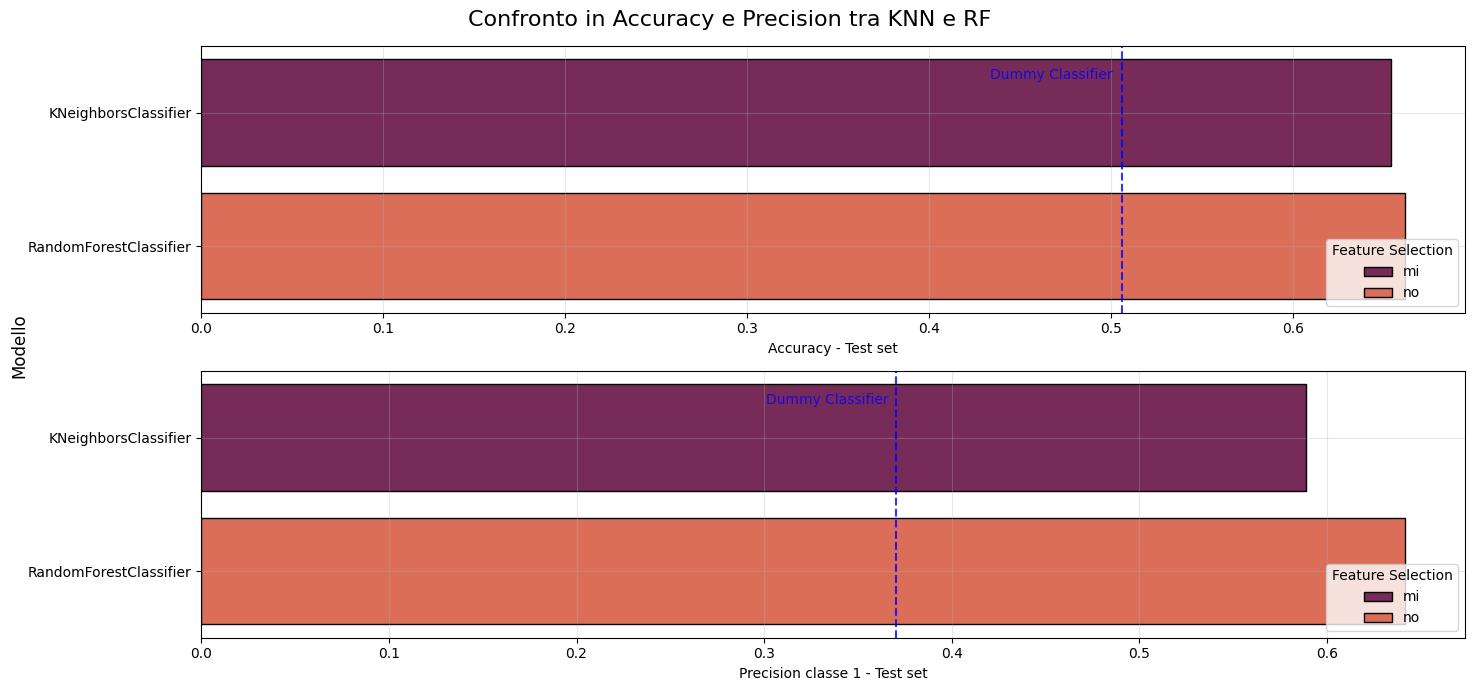

In [122]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(15,7))

ax = ax.ravel()
sns.barplot(data=best_models, y="Model Name", x='Accuracy_Test', ax=ax[0], palette='rocket', hue='Feature Selection', edgecolor='k')
sns.barplot(data=best_models, y="Model Name", x='Precision_ 1_Test', ax=ax[1], palette='rocket', hue='Feature Selection', edgecolor='k')

ax[0].set_xlabel("Accuracy - Test set")
ax[1].set_xlabel("Precision classe 1 - Test set")

ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[0].grid(alpha=0.3)
ax[1].grid(alpha=0.3)

ax[0].legend(title='Feature Selection', loc='lower right')
ax[1].legend(title='Feature Selection', loc='lower right')

ax[0].axvline(x=bench_accuracy, color='blue', ls='dashed', label='Dummy Classifier', alpha=0.8)
ax[1].axvline(x=bench_precision, color='blue', ls='dashed', label='Dummy Classifier', alpha=0.8)

ax[0].text(bench_accuracy * 0.99, ax[0].get_ylim()[1] * 0.5, 'Dummy Classifier', color='blue', alpha=0.8, fontsize=10, ha='right')
ax[1].text(bench_precision * 0.99, ax[1].get_ylim()[1] * 0.5, 'Dummy Classifier', color='blue', alpha=0.8, fontsize=10, ha='right')


fig.supylabel('Modello')

plt.suptitle('Confronto in Accuracy e Precision tra KNN e RF', fontsize=16)

plt.tight_layout()

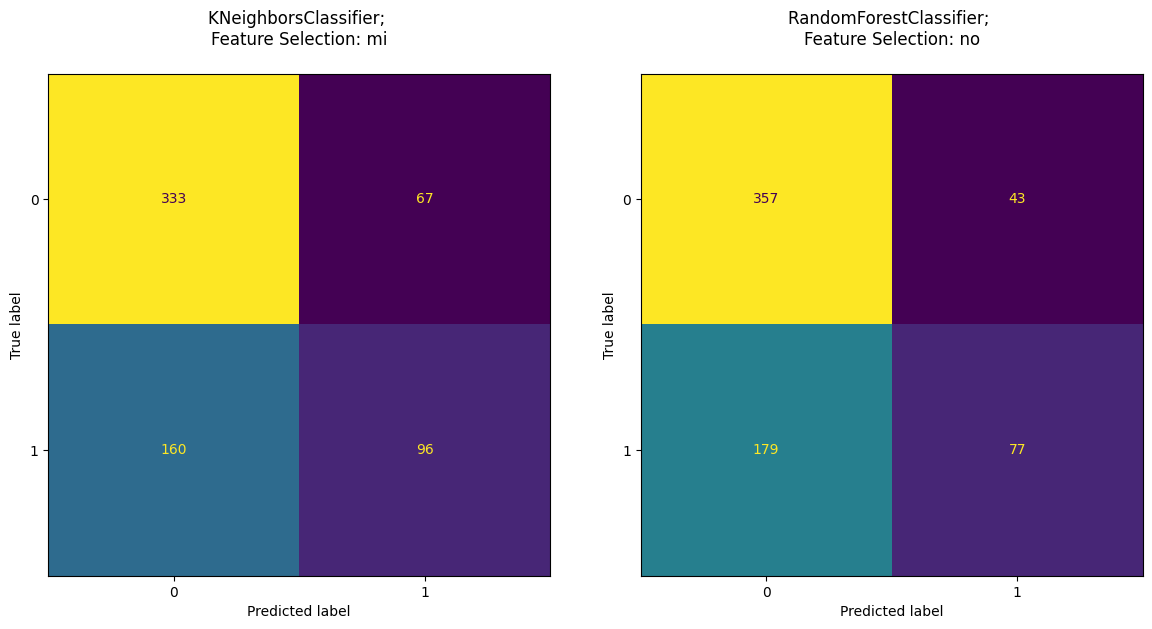

In [116]:
fig, axes = plt.subplots(1, len(best_models), figsize=(12, 6))

for (idx, row), ax in zip(best_models.iterrows(), axes):
    model = row['Modello']
    name = row['Model Name']
    feats = row['Feature Selection']
    name_model = f"{name}; \nFeature Selection: {feats}\n"
    
    if feats == 'no':
        predictions = model.predict(X_test)
    else:
        predictions = model.predict(X_test[features_mi])
        
    confmatrx = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confmatrx)
    disp.plot(ax=ax, colorbar=False)  
    ax.set_title(name_model)  

plt.tight_layout()
plt.show()

### Scelta del Modello e considerazioni conclusive

__RF classifier, tutte le features e senza oversampling, è il modello migliore per Accuracy e, sensibilmente, per Precision (in classe 1).__
<br>

Il RandomForest è uno degli algoritmi più comunemente usati nei progetti di Machine Learning, in quanto garantisce ottima flessibilità; tuttavia è un modello complesso e da ciò scaturisce la sua lentezza in addestramento (ulteriormente amplificata in caso di GridSearch) e la poca interpretabilità (essendo un _ensemble_ di tanti alberi decisionali): questo potrebbe costituire un ostacolo laddove invece fosse importante capire la motivazione dietro una scelta effettuata dal modello. Gli algoritmi in generale sono un eccellente strumento nella cassetta degli attrezzi a disposizione dell'operatore, tuttavia la loro 'potenza' ha talvolta bisogno di essere coadiuvata da una persona in possesso del cosiddetto __domain knowledge__, vale a dire esperienza o conoscenza dell'ambito di applicazione (in questo caso, la chimica). E' verosimile aspettarsi dei risultati più attendibili e soddisfacenti nel lungo termine quando queste due entità riescono a collaborare efficacemente. 

Il progetto richiede di valutare i modelli sulla base della loro Accuracy, ma mi sento di ribadire l'importanza della precisione nella classe 1 come metrica aggiuntiva di valutazione, in virtù della natura generale del problema. Un Falso Positivo significherebbe aver classificato un campione d'acqua non potabile come potabile e la problematicità di questa eventualità è piuttosto lampante. 

Complessivamente la feature selection ha influenzato le scelte: il modello che emerge come migliore è diverso rispetto all'altro caso (RF v KNN) e i risultati ottenuti dagli altri modelli sono stati leggermente più stabili, rispetto alle controparti con tutte le features in addestramento.

La accuracy del modello scelto non è altissima, ma è praticamente uguale a quella ottenuta in fase di training nella cross-validation: è verosimile che quest'ultima ha fornito una validazione robusta circa l'adattamento di questo modello rispetto a dati nuovi ed alla generalizzazione su di essi. 

L'oversampling non ha dato i frutti auspicati, complice forse la complessità del dataset e di conseguenza la difficoltà a generare nuovi samples verosimili.

#### Trade off Tempo - Performance

Algoritmi complessi implicano generalmente un maggior tempo di addestramento. In fase di addestramento RandomForest impiega moltissimo tempo in più rispetto al 'rivale' KNN, mentre in fase di previsione non ci sono differenze. 

In contesti decisionali, il tempo è un elemento critico nella selezione definitiva di un modello e influisce tanto quanto la performance ottenuta. 

Tra il privilegiare la tempestività o la performance non c'è una strada da preferire in assoluto, si tratta piuttosto di una scelta da compiere _cum grano salis_ rispetto alla natura del problema in sé. Generalmente velocità e precisione vanno in direzioni opposte e talvolta la miglior soluzione consiste nell'individuare lo __Sweet Spot__ nel continuum tra queste due metriche dicotomiche.

#### Salvataggio Modello 

In [84]:
best_model_overall = best_models.sort_values(by='Accuracy_Test', ascending=False)['Modello'].iloc[0]

In [85]:
import joblib
joblib.dump(best_model_overall, 'modello_ml.joblib')

['modello_ml.joblib']

In [86]:
model_up = joblib.load('modello_ml.joblib')